In [1]:
import numpy as np
from skimage import measure
from skimage.segmentation import find_boundaries
from skimage.morphology import opening,closing
from skimage.io import imread
from matplotlib import pyplot as plt
import os
from os import listdir
import pandas as pd
from scipy.stats import kde
import seaborn as sns
import copy
from math import exp,log
import pickle
import scipy.ndimage as ndimage
import scipy.interpolate.fitpack as fitpack
from sklearn import manifold,decomposition,random_projection,cluster,metrics,preprocessing,mixture,model_selection
from sklearn.neighbors import kneighbors_graph,BallTree
from hmmlearn import hmm
# from pymc import MCMC,flib,Model,MAP
# from ripser import Rips,ripser,plot_dgms
# from persim import PersImage
# import scipy.io as sio
# import kmapper as km
# from kmapper import jupyter
from mpl_toolkits.mplot3d import Axes3D
from cell_class import single_cell,fluor_single_cell
import contour_class
import utility_tools
import image_warp
from contour_tool import df_find_contour_points,find_contour_points,generate_contours,align_contour_to,align_contours
from scipy.signal import medfilt,wiener
from traj_class import single_cell_traj,fluor_single_cell_traj
# import bnpy
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from itertools import product
from sklearn.cluster import DBSCAN,KMeans,MeanShift
from sklearn.metrics import silhouette_score,davies_bouldin_score
import glob
from pykalman import KalmanFilter
from neupy import algorithms, utils
from scipy.spatial import Voronoi, voronoi_plot_2d
from tslearn.utils import to_time_series,to_time_series_dataset
from tslearn.clustering import TimeSeriesKMeans,KShape,GlobalAlignmentKernelKMeans,silhouette_score
from tslearn.metrics import soft_dtw,dtw,dtw_path,dtw_subsequence_path,cdist_gak,cdist_dtw,cdist_soft_dtw_normalized,cdist_soft_dtw
from tslearn.barycenters import dtw_barycenter_averaging, softdtw_barycenter,euclidean_barycenter
from sklearn.manifold import MDS,TSNE,SpectralEmbedding
from scipy import signal,stats
from statsmodels.tsa.ar_model import AR
from numpy import linalg
from scipy.interpolate import CubicSpline,interp1d
from reactive_traj_classify import find_reaction_start_end,ar1_tipping_time,cross_corr_delay,find_intermediate_part
from sklearn.utils import shuffle
from reaction_coordinates import FindPath
from voronoi_finite_polygons_2d import voronoi_finite_polygons_2d
from scipy.interpolate import splprep,splev
from sklearn.cluster import DBSCAN
from scipy import interpolate
from matplotlib import patches

C:\Users\zoro\Anaconda3\envs\myconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\zoro\Anaconda3\envs\myconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\zoro\Anaconda3\envs\myconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\zoro\Anaconda3\envs\myconda3\lib\site-packages\tensorflow\

In [3]:
main_path='single_cell_traj/'

sct_path=main_path+'4ng_traj/'
print(sct_path)
#sct_list=sorted(listdir(sct_path))
sct_list=sorted(glob.glob(sct_path+'*long_traj'))
print(len(sct_list))
result_path=main_path+'rc_result/'

with open (main_path+'morph_pc_scaler','rb') as fp:
    morph_pc_scaler=pickle.load(fp,encoding='iso-8859-1')

with open (main_path+'vim_pc_scaler','rb') as fp:
    vim_pc_scaler=pickle.load(fp,encoding='iso-8859-1')
    
with open (main_path+'label_spread_4d','rb') as fp:
    ls=pickle.load(fp,encoding='iso-8859-1')

    
t_start=0
t_end=577

single_cell_traj/4ng_traj/
217


C:\Users\zoro\Anaconda3\envs\myconda3\lib\site-packages\sklearn\base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.2 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zoro\Anaconda3\envs\myconda3\lib\site-packages\sklearn\base.py:315: UserWarning: Trying to unpickle estimator NearestNeighbors from version 0.23.2 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\zoro\Anaconda3\envs\myconda3\lib\site-packages\sklearn\base.py:315: UserWarning: Trying to unpickle estimator LabelSpreading from version 0.23.2 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [6]:
path=np.load(result_path+'path.npy')
extend_path=np.load(result_path+'extend_path.npy')
print(len(extend_path)-len(path))
extend_range=int((len(extend_path)-len(path))/2)
path_dsdt=np.load(result_path+'dSdt.npy')

branch_start=3
branch_end=27
nrc=24

6


In [7]:
all_traj=[]
all_t=[]
all_traj_state=[]

all_reaction_traj_fd=[]
all_reaction_traj=[]
all_reaction_t=[]
all_reaction_state=[]
cut_reaction_traj=[]
cut_reaction_traj_fd=[]
cut_reaction_t=[]
reactive_inds=[]
non_reactive_inds=[]
traj_ind=0

for i in range(len(sct_list)):
    with open (sct_list[i], 'rb') as fp:
        sct = pickle.load(fp,encoding='iso-8859-1')
    if hasattr(sct,'traj_scale_cord') and hasattr(sct,'traj_vimentin_scale_haralick_pca_cord'):
        if sct.traj_scale_cord is not None:
            mask=sct.traj_vimentin_feature_values[0]!=0


            traj_t=sct.traj_seri[mask][:,0]
#             morph_traj=morph_pc_scaler.transform(sct.traj_scale_cord[mask])
#             vim_traj=vim_pc_scaler.transform(sct.traj_vimentin_scale_haralick_pca_cord[mask])
            morph_traj=(sct.traj_scale_cord[mask]-morph_pc_scaler.mean_)/np.sqrt(morph_pc_scaler.var_)
            vim_traj=(sct.traj_vimentin_scale_haralick_pca_cord[mask]-vim_pc_scaler.mean_)/np.sqrt(vim_pc_scaler.var_)

            X0=np.column_stack((morph_traj,vim_traj))
            X=np.column_stack((morph_traj[:,0],vim_traj[:,[0,2,3]]))
            X[:,2]=-X[:,2]

            

            traj_state=ls.predict(X)
            traj_proba=ls.predict_proba(X)
            
            all_traj.append(X)
            all_t.append(traj_t)
            all_traj_state.append(traj_state)#[np.where(traj_t<t_end)]


            reaction_start,reaction_end,enter_M=find_reaction_start_end(traj_state,dwell_thres=3)
            if reaction_end>reaction_start:
                reaction_start_t=traj_t[reaction_start]
                reaction_end_t=traj_t[reaction_end]
                print('t',reaction_start_t,reaction_end_t)
            

                if reaction_start_t<=144 and reaction_end_t>144:

                    print(reaction_start,reaction_end)

                    reaction_traj=X[reaction_start:reaction_end+1,:]
                    reaction_state=traj_state[reaction_start:reaction_end+1]
                    all_reaction_traj.append(reaction_traj)
                    all_reaction_state.append(reaction_state)
                    cut_reaction_traj.append(X[reaction_start:enter_M+1,:])
                    all_reaction_t.append(traj_t[reaction_start:reaction_end+1])
                    reactive_inds.append(traj_ind)
                    all_reaction_traj_fd.append(X0[reaction_start:reaction_end+1,:])
                else:
                    non_reactive_inds.append(traj_ind)
                    




            else:
                non_reactive_inds.append(traj_ind)
                
            traj_ind+=1

t 9.0 577.0
4 258
t 19.0 577.0
9 284
t 1.0 577.0
0 236
t 1.0 577.0
0 284
t 1.0 577.0
0 285
t 5.0 577.0
2 277
t 1.0 273.0
0 135
t 1.0 455.0
0 220
t 1.0 415.0
0 202
t 1.0 577.0
0 274
t 1.0 427.0
0 205
t 1.0 575.0
0 283
t 1.0 539.0
0 266
t 27.0 259.0
11 123
t 7.0 431.0
0 210
t 41.0 525.0
1 240
t 1.0 511.0
0 252
t 65.0 557.0
0 243
t 1.0 567.0
0 272
t 1.0 577.0
0 274
t 1.0 545.0
0 267
t 1.0 577.0
0 283
t 1.0 577.0
0 282
t 1.0 577.0
0 283
t 1.0 577.0
0 258
t 1.0 577.0
0 283
t 1.0 577.0
0 265
t 57.0 577.0
0 255
t 59.0 411.0
1 173
t 5.0 577.0
2 282
t 1.0 393.0
0 192
t 1.0 409.0
0 197
t 1.0 547.0
0 266
t 3.0 577.0
1 280
t 7.0 387.0
2 190
t 1.0 371.0
0 182
t 1.0 577.0
0 255
t 11.0 577.0
5 283
t 1.0 577.0
0 284
t 9.0 427.0
4 208
t 15.0 577.0
7 286
t 1.0 417.0
0 206
t 1.0 575.0
0 284
t 1.0 569.0
0 281
t 1.0 577.0
0 286
t 1.0 577.0
0 284
t 5.0 427.0
2 206
t 1.0 577.0
0 281
t 15.0 545.0
7 268
t 1.0 577.0
0 281
t 1.0 577.0
0 283
t 1.0 577.0
0 284
t 1.0 577.0
0 282
t 1.0 577.0
0 283
t 9.0 577.0
4 285


In [8]:
print(len(all_traj))
print(len(all_reaction_traj))

204
135


[1 1 1 0 0 1 0 1 1 1 1 1 0 1 1 1 1 1 0 0 0 1 0 1 0 1 0 1 0 1 0 1 0 0 1 0 1
 0 1 1 0 0 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 0 1 0 1 1 1 0 1 1 1 1 1 1 1 1
 1 1 0 1 1 1 1 0 0 0 1 0 1 0 1 1 0 1 0 0 1 1 0 0 1 1 0 1 0 1 0 1 0 0 1 1 1
 0 1 1 1 0 0 1 1 1 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0] 54


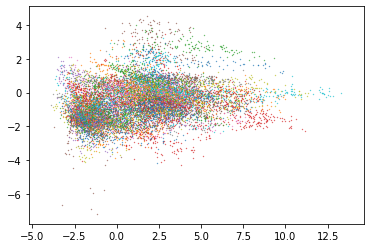

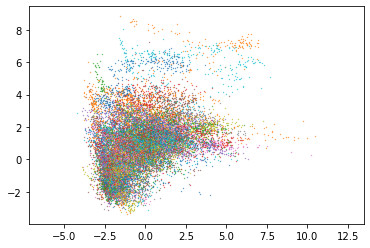

In [9]:
X=to_time_series_dataset(all_reaction_traj)
km_dba = TimeSeriesKMeans(n_clusters=2, metric="dtw",max_iter=10,max_iter_barycenter=10,random_state=0).fit(X)#metric_params={"gamma": 20}, 
Y=km_dba.labels_


print(Y,len(Y[Y==0]))
# dot_color=np.arange(km_dba.cluster_centers_.shape[1])
# cm=plt.get_cmap('jet')
for i in range(len(X)):
    if Y[i]==0:
        plt.scatter(X[i][:,0],X[i][:,1],s=0.1)
# print(km_dba.cluster_centers_.shape)
# plt.scatter(km_dba.cluster_centers_[0,:,0],km_dba.cluster_centers_[0,:,1],s=15,c=dot_color,cmap=cm)
plt.axis('equal')

plt.show()

for i in range(len(X)):
    if Y[i]==1:
        plt.scatter(X[i][:,0],X[i][:,1],s=0.1)
#plt.scatter(km_dba.cluster_centers_[1,:,0],km_dba.cluster_centers_[1,:,1],s=15,c=dot_color,cmap=cm)
plt.axis('equal')
plt.show()

In [10]:
print(len(Y[Y==0]))
print(len(Y[Y==1]))

54
81


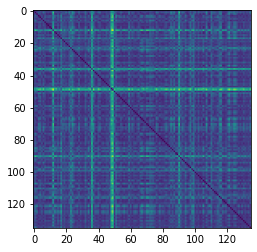

In [11]:
sct_cdist=cdist_dtw(X)
# sct_cdist=cdist_soft_dtw_normalized(X,gamma=1)
# np.save(result_path+'sct_soft_cdist.npy',sct_cdist)

plt.imshow(sct_cdist)
plt.show()

C:\Users\zoro\Anaconda3\envs\myconda3\lib\site-packages\sklearn\manifold\_t_sne.py:699: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  FutureWarning


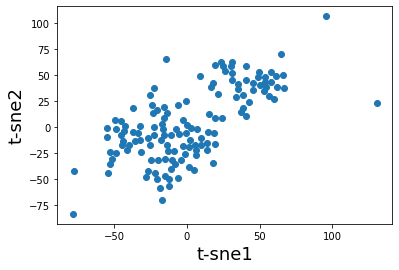

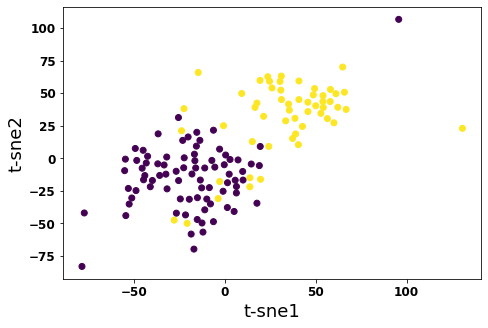

In [12]:
tsne = TSNE(n_components=2, perplexity=10.0,early_exaggeration=30.0,  metric='precomputed')
Y1 = tsne.fit_transform(sct_cdist)

plt.scatter(Y1[:,0],Y1[:,1])
plt.xlabel('t-sne1',fontsize=18)
plt.ylabel('t-sne2',fontsize=18)
plt.show()

plt.figure(figsize=(7.5,5))
plt.scatter(Y1[:,0],Y1[:,1],c=1-Y)

plt.xlabel('t-sne1',fontsize=18)
plt.ylabel('t-sne2',fontsize=18)
plt.xticks(fontsize=12,fontweight='bold')
plt.yticks(fontsize=12,fontweight='bold')
# plt.savefig(result_path+'4ng_traj_sct_tsne.tif',dpi=300)
plt.show()

In [13]:
data_rc=[]
for ind in range(len(all_reaction_traj)):
    traj_t_span=all_reaction_traj[ind].shape[0]
    traj_rc=np.zeros((all_reaction_traj[ind].shape[0],))
    for i in range(traj_t_span):
        p = all_reaction_traj[ind][i,:]
        dist = linalg.norm(extend_path - p[None,:], axis = 1)
        traj_rc[i]=np.argmin(dist)
#     plt.scatter(np.arange(traj_rc.shape[0]-1),np.diff(traj_rc)/2.0)
#     plt.show()
    data_rc.append(traj_rc)
print(len(data_rc))

135


In [14]:
len(data_rc)/len(all_traj)

0.6617647058823529

In [15]:
branch_traj_cl0=[]
branch_traj_cl1=[]
for i in range(len(data_rc)):
    mask=((data_rc[i]>branch_start)&(data_rc[i]<branch_end))
    if Y[i]==0:

#         trans_t=all_reaction_t[i][mask]
#         trans_rc=data_rc[i][mask]
        branch_traj_cl0.append(all_reaction_traj[i][mask])
    else:
        branch_traj_cl1.append(all_reaction_traj[i][mask])


In [16]:
class FindPath(object):
    def __init__(self, n = 20,traj_w=10,sf=1):
        self.n = n
        self.t = np.linspace(0,1,n)
        self.error = 1e100
        self.error_log=[]
        self.data_rc=[]
        self.tangent_v=[]
        self.w=traj_w
        self.sf=sf
        
    def fit(self, p1, p2,data):
        self.p1 = np.expand_dims(p1,axis=0)
        self.p2 = np.expand_dims(p2,axis=0)
        self.data = data
        self.cluster_labels=[]

        self.spline = p1 + np.multiply((p2 - p1) , np.expand_dims(self.t,axis=1))
        plt.plot(self.spline[:,0], self.spline[:,1]) 
        plt.show()
        
        self.best_spline=self.spline.copy()
        
        update=True
        while update:
            update=self.__move()
#             if len(self.error_log)>=2:
#                 if abs(self.error_log[-1]-self.error_log[-2])/self.error_log[-1]<0.005:
#                     update=False
#                 else:
#                     update=True
#             else:
#                 update=True
            print(update)


        return self.best_spline,self.data_rc
    
    def __move(self):
        


        w=self.w
        traj_error_arr1,traj_sum1,pts_error_arr1,pts_sum1,density1,data_rc1=self.__error() 
        centers = self.spline.copy()

        updateIndexs = np.where(density1>0)[0]
        centers[updateIndexs,:]=(np.divide(pts_sum1[updateIndexs,:],np.expand_dims(density1[updateIndexs],axis=1))+\
                                w*traj_sum1[updateIndexs,:]/len(self.data))/(1+w)



        self.spline,tangent_v=self.__discretize(centers)
        
        dot_color=np.arange(self.spline.shape[0])
        cm=plt.cm.get_cmap('jet')
        plt.figure(figsize=(7.5,5))
        plt.scatter(self.spline[:,0],self.spline[:,1],c=dot_color,cmap=cm)
        plt.xlabel('Morphology PC1',fontsize=16,fontweight='bold')
        plt.ylabel('Vimentin Haralick PC1',fontsize=16,fontweight='bold')
        plt.xticks(fontsize=14,fontweight='bold')
        plt.yticks(fontsize=14,fontweight='bold')
#         plt.savefig(str(self.error)+'.png',dpi=300)
        plt.show()

        traj_error_arr2,traj_sum2,pts_error_arr2,pts_sum2,density2,data_rc2=self.__error() 

#         print(w*np.sum(traj_error_arr2),np.sum(pts_error_arr2))
        error=w*np.sum(traj_error_arr2)+np.sum(pts_error_arr2)


        self.error_log.append(error)

        if error<self.error:
            self.error=error
            self.best_spline=self.spline.copy()
            self.data_rc=data_rc2
            self.tangent_v=tangent_v
            return True
        else:
            return False

        

    def __discretize(self,centers,sample_n=1,st_move=0.05):

        
        spline=centers.copy()
        centers[0,:]=self.p1#+st_move*(centers[0,:]-self.p1)#self.spline[0,:]+st_move*(centers[0,:]-self.spline[0,:])
        centers[-1,:]=self.p2#+st_move*(centers[-1,:]-self.p2)#self.spline[-1,:]+st_move*(centers[-1,:]-self.spline[-1,:])
        t = np.linspace(0,1, sample_n* self.n)

        



        center_list=[centers[:,i] for i in range(centers.shape[1])]
        tck, u = interpolate.splprep(center_list,s=self.sf,k=2)
        spline_list=splev(t,tck,ext=3)
        for k in range(len(spline_list)):
            spline[:,k]=spline_list[k][::sample_n]

        tangent_v=interpolate.splev(t,tck,der=1)
        
        return spline,tangent_v
        
    def __error(self):
        
        
        pts_error_arr=np.zeros(self.n)
        density = np.zeros(self.n)
        pts_sum=np.zeros_like(self.spline)
        
        traj_error_arr=np.zeros(self.n)
        traj_sum=np.zeros_like(self.spline)
        data_rc=[]
        for ind in range(len(self.data)):
            traj_t_span = self.data[ind].shape[0]
            spline_inds=[]
            spline_dist=[]
            for j in range(self.n):
                p=self.spline[j]
                
                dist=linalg.norm(self.data[ind]-p[None,:],axis=1)
#                 print(dist.shape)
                traj_error_arr[j]+=np.amin(dist)
                traj_sum[j]+=self.data[ind][np.argmin(dist),:]
#-------------this will make the RC messy---------
#             rc_dtw_path=np.asarray(dtw_path(self.data[ind],self.spline)[0])
# #             print(len(rc_dtw_path),len(self.data[ind]))
#             for j in range(self.n):
#                 p=self.spline[j]
#                 match_inds=rc_dtw_path[:,0][np.where(rc_dtw_path[:,1]==j)]
#                 traj_sum[j]+=len(match_inds)
#                 print(match_inds)
#                 traj_error_arr[j]+=np.sum(linalg.norm(self.data[ind][match_inds,:]-p[None,:],axis=1))
#----------------------------------------------                

            traj_rc=np.zeros((self.data[ind].shape[0],))
            for i in range(traj_t_span):
                p = self.data[ind][i,:]
                dist = linalg.norm(self.spline - p[None,:], axis = 1)
                pts_error_arr[np.argmin(dist)]+=np.amin(dist)
                pts_sum[np.argmin(dist)]+=self.data[ind][i,:]
                density[np.argmin(dist)]+=1
                traj_rc[i]=np.argmin(dist)
            data_rc.append(traj_rc)
            
#             traj_rc=np.zeros((self.data[ind].shape[0],))
#             rc_dtw_path=np.asarray(dtw_path(self.data[ind],self.spline)[0])
#             for i in range(traj_t_span):
#                 p = self.data[ind][i,:]
#                 p_match=rc_dtw_path[:,1][rc_dtw_path[:,0]==i]
#                 dist = linalg.norm(self.spline[p_match] - p[None,:], axis = 1)
# #                 print(dist)
#                 pts_error_arr[p_match[np.argmin(dist)]]+=np.amin(dist)
#                 pts_sum[p_match[np.argmin(dist)]]+=self.data[ind][i,:]
#                 density[p_match[np.argmin(dist)]]+=1
#                 traj_rc[i]=p_match[np.argmin(dist)]
#             data_rc.append(traj_rc)

        return traj_error_arr,traj_sum,pts_error_arr,pts_sum,density,data_rc

In [17]:
# branch_nrc=branch_end-branch_start
# X0=branch_traj_cl1
# x1=extend_path[branch_start,:]#
# x2=extend_path[branch_end,:]#

# FP=FindPath(branch_nrc,traj_w=10,sf=1)
# path1,data_rc1=FP.fit(x1,x2,X0)

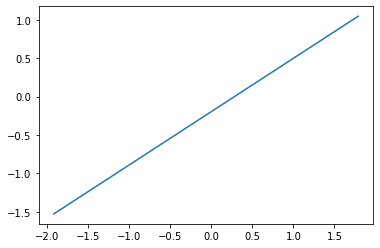

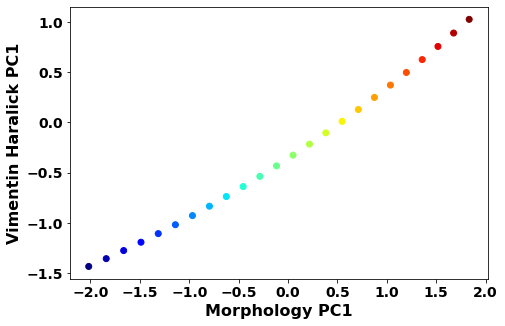

True


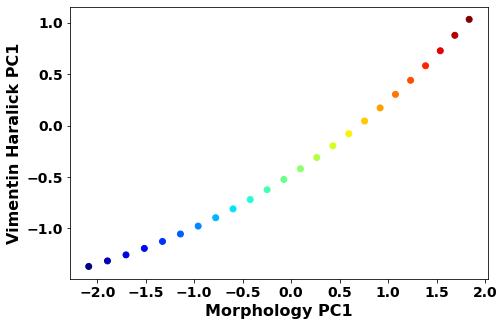

True


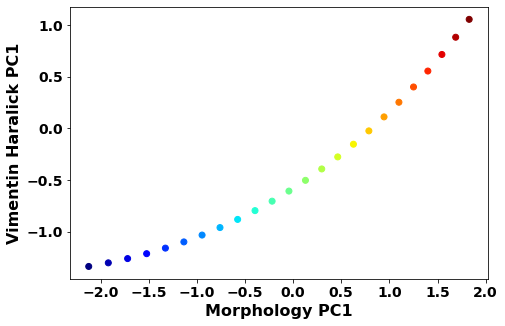

True


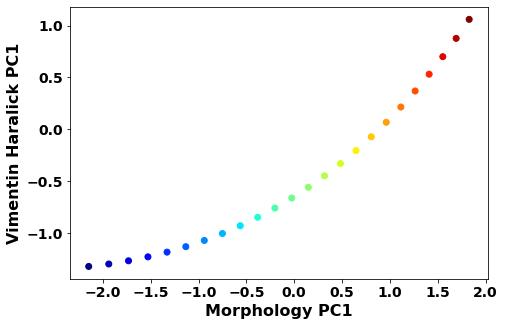

True


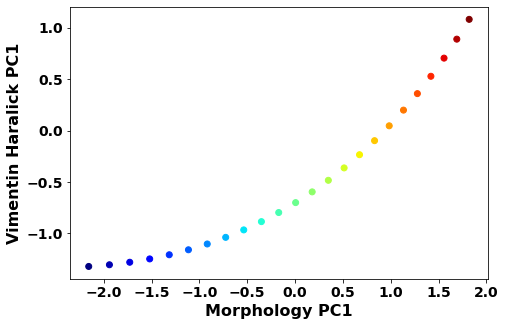

True


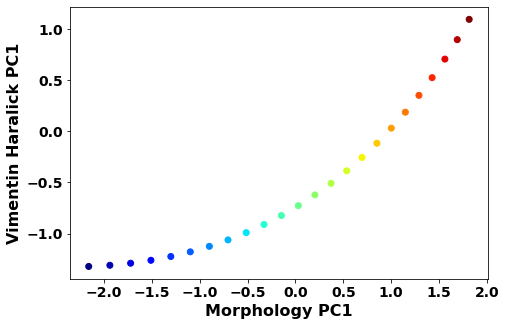

True


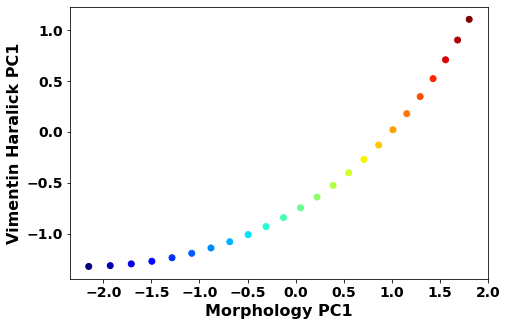

True


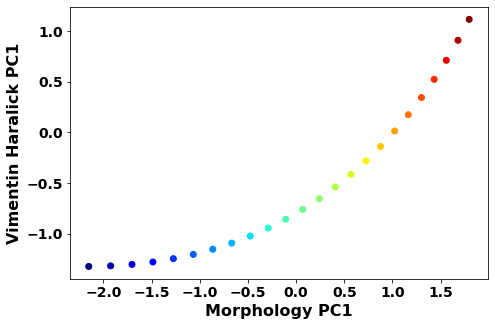

True


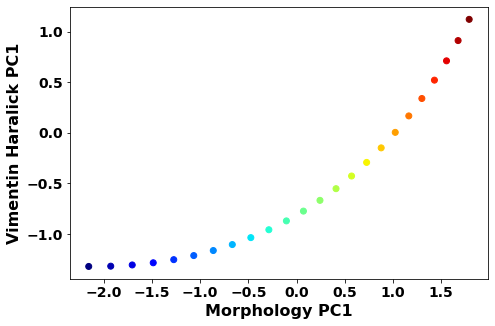

True


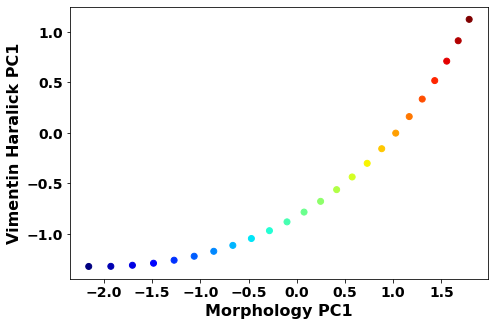

True


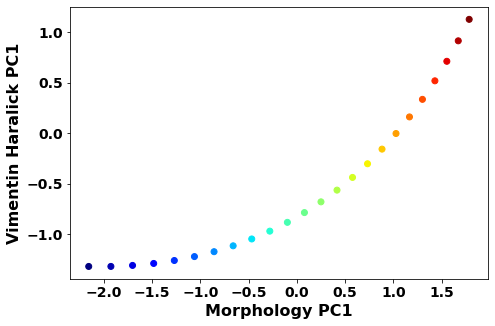

True


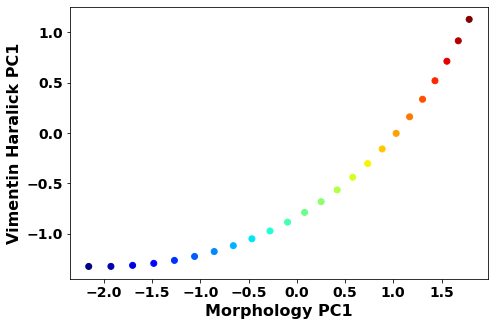

False


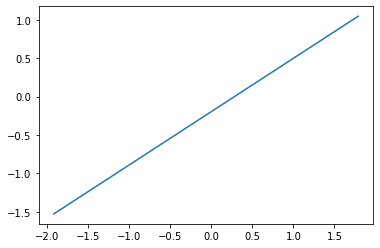

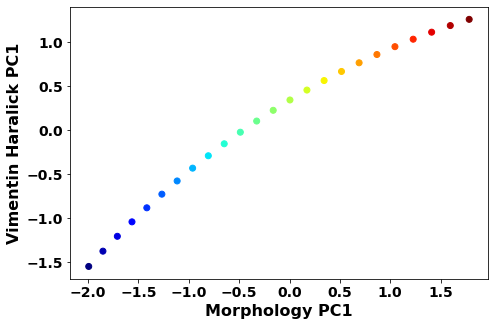

True


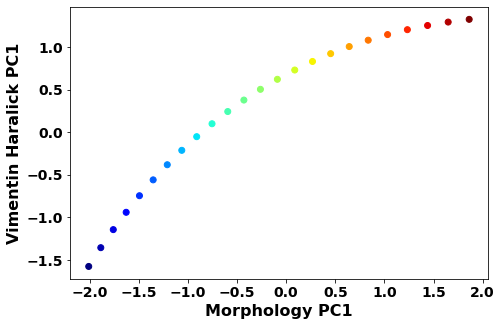

True


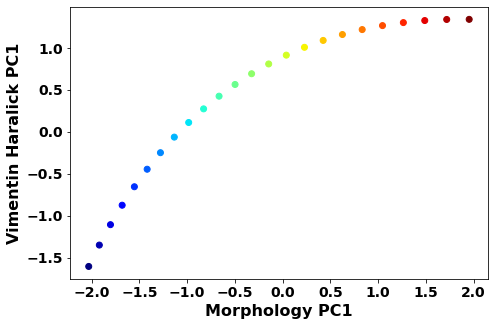

True


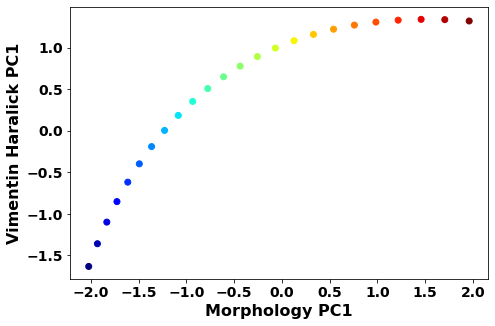

True


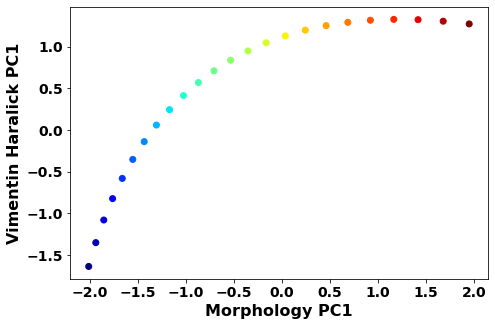

True


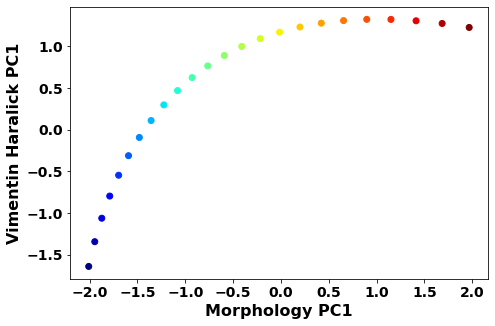

True


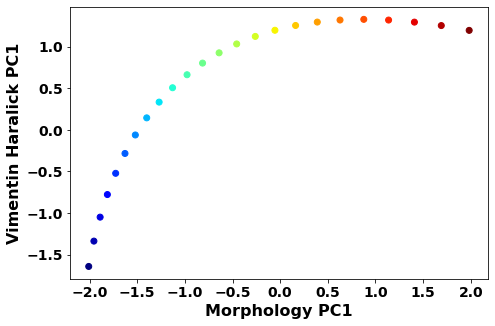

True


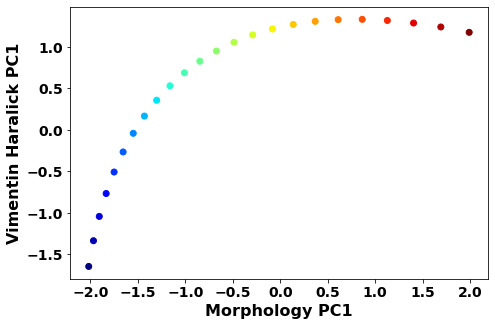

True


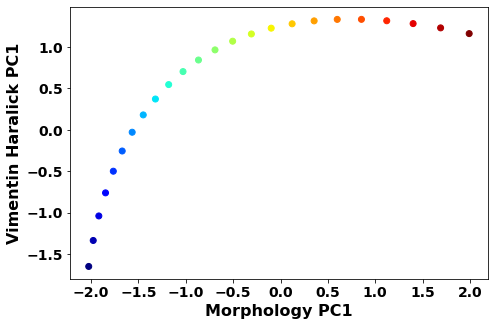

True


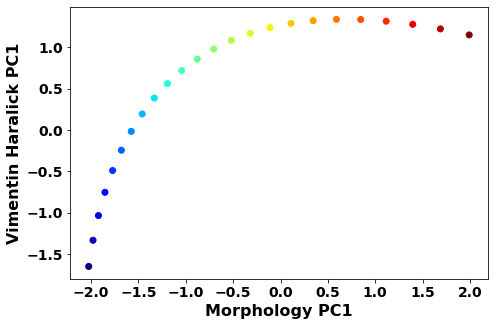

True


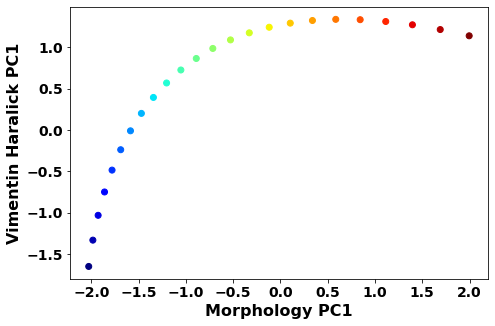

True


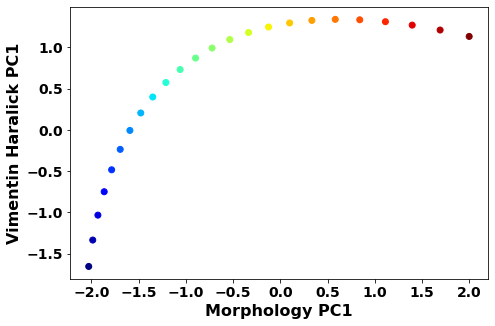

True


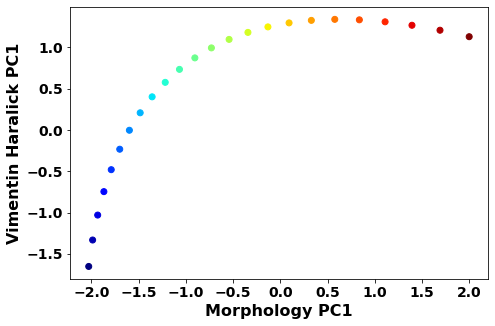

True


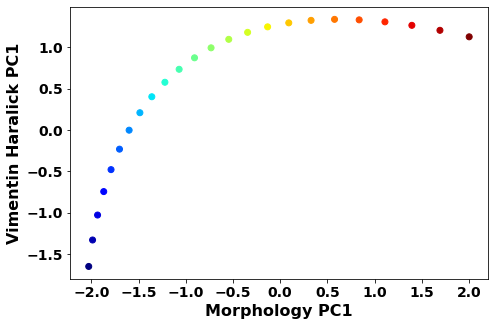

True


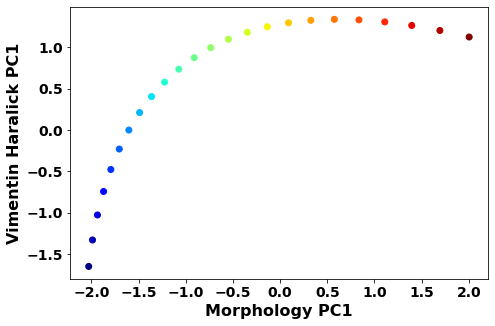

True


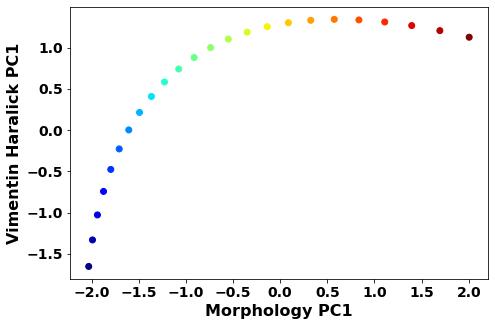

True


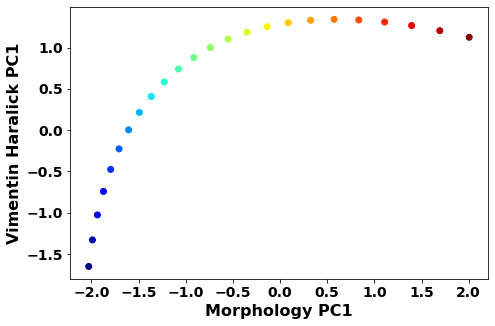

True


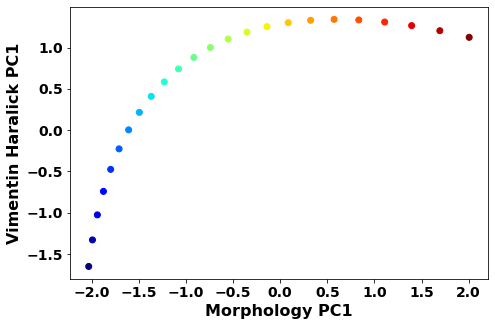

True


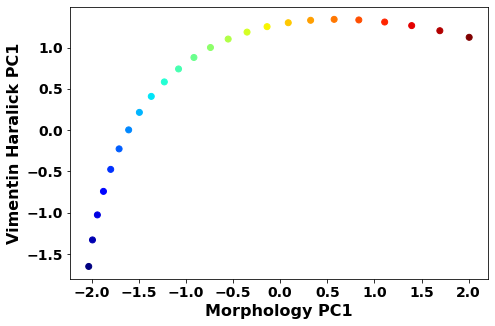

True


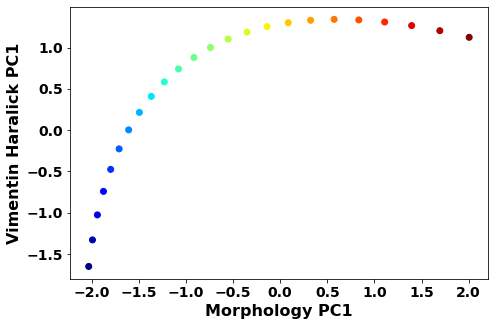

True


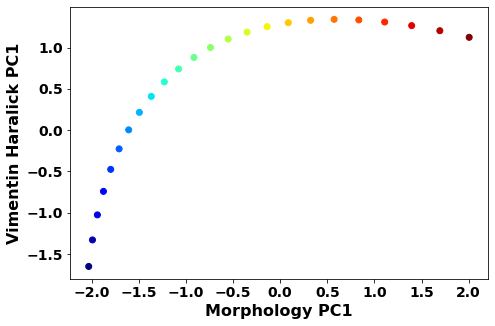

False


In [18]:
branch_nrc=branch_end-branch_start
X0=branch_traj_cl0
x1=extend_path[branch_start,:]#
x2=extend_path[branch_end,:]#

FP=FindPath(branch_nrc,traj_w=10,sf=1)
path0,data_rc0=FP.fit(x1,x2,X0)


X0=branch_traj_cl1
x1=extend_path[branch_start,:]#
x2=extend_path[branch_end,:]#

FP=FindPath(branch_nrc,traj_w=10,sf=1)
path1,data_rc1=FP.fit(x1,x2,X0)

np.save(result_path+'path0.npy',path0)
np.save(result_path+'path1.npy',path1)
# dot_color1=np.arange(X0[0].shape[0])

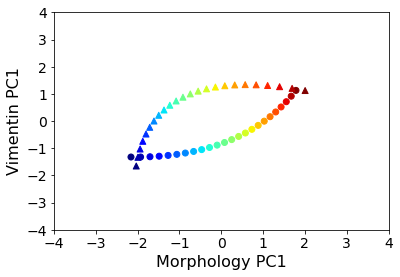

In [19]:
dot_color2=np.arange(path0.shape[0])
cm=plt.cm.get_cmap('jet')

plt.scatter(path0[:,0],path0[:,1],c=dot_color2,cmap=cm)
plt.scatter(path1[:,0],path1[:,1],c=dot_color2,marker='^',cmap=cm)

plt.xlabel('Morphology PC1',fontsize=16)
plt.ylabel('Vimentin PC1',fontsize=16)
plt.axis([-4,4,-4,4])
# lgnd=plt.legend(fontsize=12)
# lgnd.legendHandles[0]._sizes = [40]
# lgnd.legendHandles[1]._sizes = [40]
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig(result_path+'rc_2path.png',dpi=300)

plt.show()

In [20]:
extend_path0=extend_path.copy()
extend_path0[branch_start:branch_end,:]=path0

extend_path0_list=[extend_path0[:,i] for i in range(extend_path0.shape[1])]
# print(extend_path0_list)
tck, u = interpolate.splprep(extend_path0_list,s=0.25,k=2)
spline_list=splev(np.linspace(0,1, len(extend_path)),tck,ext=3)
for k in range(len(spline_list)):
    extend_path0[:,k]=spline_list[k]
# extend_path0[:branch_start,:]=extend_path[:branch_start,:]
# extend_path0[branch_end:,:]=extend_path[branch_end:,:]

In [21]:
extend_path1=extend_path.copy()
extend_path1[branch_start:branch_end,:]=path1

extend_path1_list=[extend_path1[:,i] for i in range(extend_path1.shape[1])]
# print(extend_path1_list)
tck, u = interpolate.splprep(extend_path1_list,s=0.25,k=2)
spline_list=splev(np.linspace(0,1, len(extend_path)),tck,ext=3)
for k in range(len(spline_list)):
    extend_path1[:,k]=spline_list[k]

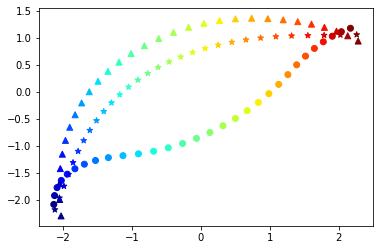

In [22]:
dot_color=np.arange(extend_path.shape[0])
cm=plt.cm.get_cmap('jet')

plt.scatter(extend_path0[:,0],extend_path0[:,1],c=dot_color,cmap=cm)
plt.scatter(extend_path1[:,0],extend_path1[:,1],c=dot_color,marker='^',cmap=cm)

plt.scatter(extend_path[:,0],extend_path[:,1],c=dot_color,marker='*',cmap=cm)
plt.show()

np.save(result_path+'extend_path0.npy',extend_path0)
np.save(result_path+'extend_path1.npy',extend_path1)

In [23]:
data_rc=[]
for ind in range(len(all_traj)):
    traj_t_span=all_traj[ind].shape[0]
    traj_rc=np.zeros((all_traj[ind].shape[0],))
    for i in range(traj_t_span):
        p = all_traj[ind][i,:]
        dist = linalg.norm(extend_path - p[None,:], axis = 1)
        traj_rc[i]=np.argmin(dist)
#     plt.scatter(np.arange(traj_rc.shape[0]-1),np.diff(traj_rc)/2.0)
#     plt.show()
    data_rc.append(traj_rc)
print(len(data_rc))

204


In [24]:
rc_grad=[[] for i in range(len(extend_path))]
rc_grad_sign=[[] for i in range(len(extend_path))]
rc_pts=[[] for i in range(len(extend_path))]


rc_real_grad=[[] for i in range(len(extend_path))]

for i in range(len(all_traj)):
    rc_traj=data_rc[i]
#     print(rc_traj)
    traj_len=rc_traj.shape[0]-1
    traj_t=all_t[i]
    rc_traj_grad=np.diff(rc_traj,axis=0)
    traj_grad=np.diff(all_traj[i],axis=0)

    for t_ind in np.where((traj_t>=t_start)&(traj_t<t_end))[0][:-1]:
        rc_grad[int(rc_traj[t_ind])].append((rc_traj[t_ind+1]-rc_traj[t_ind])*1.0/(traj_t[t_ind+1]-traj_t[t_ind]))
        rc_grad_sign[int(rc_traj[t_ind])].append(np.sign((rc_traj[t_ind+1]-rc_traj[t_ind])*1.0/(traj_t[t_ind+1]-traj_t[t_ind])))
        rc_pts[int(rc_traj[t_ind])].append(all_traj[i][t_ind,:])
        rc_real_grad[int(rc_traj[t_ind])].append(traj_grad[t_ind,:])

In [25]:
rc_flux_v=np.zeros((len(extend_path),))
rc_flux_D=np.zeros((len(extend_path),))
for j in range(len(extend_path0)):
#     plt.hist(np.array(rc_grad[j]))
#     plt.show()
    rc_flux_v[j]=np.mean(np.array(rc_grad[j]))
    rc_flux_D[j]=np.var(np.array(rc_grad[j]))

In [26]:
def consecutive_arrs(data, stepsize=1):
    return np.split(data, np.where(np.diff(data)>stepsize)[0]+1)


rc0 [ 9 10 11 12 13 14]
[0. 0. 1. 1. 1. 1.]
rc0 [16 17 18 19 20 21]
[1. 0. 0. 0. 1. 0.]
rc0 [25 26 27 28]
[3. 5. 4. 4.]
rc1 [0 1 2 3 4 5 6 7 8]
[0. 0. 0. 0. 0. 0. 0. 1. 0.]
rc1 [22 23 24]
[1. 0. 0.]
rc1 [32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52]
[2. 2. 3. 3. 3. 3. 4. 5. 4. 4. 4. 5. 6. 5. 5. 6. 5. 4. 8. 7. 5.]
rc1 [54 55 56]
[5. 7. 6.]
rc1 [58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75]
[8. 8. 9. 7. 8. 8. 9. 9. 8. 9. 8. 9. 8. 9. 9. 9. 6. 8.]
rc1 [ 77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94
  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130
 131 132 133 134 135 136 137 138 139]
[11.  8. 10.  9.  9. 10. 10. 11. 10. 11. 10. 11. 10. 11. 11. 11. 10. 12.
 11. 11. 12. 12. 13. 12. 12. 12. 13. 12. 12. 12. 12. 11. 13. 13. 13. 13.
 13. 14. 13. 14. 15. 15. 15. 15. 14. 15. 15. 15. 15. 14. 14. 14. 16. 16.
 14. 15. 16. 19. 16. 19. 17. 21. 19.]
rc1 [14

rc0 [138 139 140 141]
[7. 9. 7. 8.]
rc0 [147 148 149 150 151]
[ 7.  9.  6. 10. 10.]
rc0 [175 176 177 178 179]
[5. 7. 1. 6. 7.]
rc1 [28 29 30 31 32 33]
[1. 1. 0. 0. 0. 0.]
rc1 [43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66
 67 68 69 70 71 72 73 74 75]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0.]
rc1 [77 78 79]
[0. 0. 0.]
rc1 [81 82 83 84 85 86 87 88 89]
[0. 0. 0. 0. 0. 0. 0. 0. 0.]
rc1 [133 134 135 136 137]
[8. 8. 6. 7. 8.]
rc1 [152 153 154 155 156 157 158 159 160 161 162 163]
[7. 5. 6. 6. 4. 8. 6. 4. 4. 4. 3. 3.]
rc1 [169 170 171]
[5. 3. 3.]
rc1 [180 181 182 183]
[3. 5. 9. 5.]
rc1 [191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208
 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226
 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244
 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262
 263 264 265 266 267 268 269 270 271 

rc0 [28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51
 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73]
[ 9.  8. 12. 12. 15. 15. 12. 13. 12. 13. 11. 12. 11. 11. 11. 11. 14. 14.
 14. 14. 16. 14. 16. 16. 15. 17. 18. 15. 13. 15. 15. 15. 10. 15. 14. 15.
 13. 18. 17. 19. 15. 12. 17. 18. 15. 18.]
rc0 [75 76 77 78 79 80 81 82 83 84 85 86 87 88]
[18. 15. 15. 18. 18. 18. 19. 14. 14. 13. 19. 20. 19. 19.]
rc0 [90 91 92 93 94]
[21. 19. 20. 21. 19.]
rc0 [272 273 274]
[21. 21. 20.]
rc1 [ 6  7  8  9 10 11 12 13 14 15]
[6. 5. 3. 5. 4. 4. 4. 5. 4. 5.]
rc1 [24 25 26 27]
[4. 5. 6. 5.]
rc1 [ 95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112
 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130
 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148
 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166
 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184
 185 186 187 188 

rc1 [222 223 224 225 226]
[29. 29. 29. 29. 29.]
rc0 [3 4 5 6]
[2. 2. 1. 3.]
rc0 [20 21 22 23]
[3. 4. 3. 6.]
rc0 [ 95  96  97  98  99 100 101 102 103 104]
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
rc0 [111 112 113]
[0. 0. 0.]
rc0 [115 116 117]
[0. 0. 1.]
rc0 [135 136 137 138 139 140 141 142 143 144 145]
[ 9.  9.  9. 10.  9.  7. 10. 10.  8.  8.  7.]
rc0 [148 149 150 151 152 153 154 155 156 157 158]
[10. 10. 10. 10. 10. 10. 10. 10. 10. 10. 10.]
rc1 [0 1 2]
[0. 1. 1.]
rc1 [7 8 9]
[4. 3. 3.]
rc1 [24 25 26 27 28 29 30]
[2. 2. 1. 1. 0. 1. 1.]
rc1 [32 33 34 35 36]
[0. 1. 0. 1. 1.]
rc1 [38 39 40 41]
[0. 0. 0. 0.]
rc1 [44 45 46]
[0. 0. 0.]
rc1 [48 49 50 51 52 53]
[1. 1. 1. 0. 1. 1.]
rc1 [56 57 58 59]
[1. 1. 0. 0.]
rc1 [67 68 69 70 71 72 73 74 75]
[3. 4. 4. 3. 3. 3. 4. 3. 3.]
rc1 [81 82 83 84 85 86]
[3. 4. 4. 4. 4. 4.]
rc1 [90 91 92 93 94]
[3. 4. 3. 3. 2.]
rc1 [105 106 107]
[1. 1. 1.]
rc1 [120 121 122 123 124]
[0. 0. 0. 0. 0.]
rc1 [126 127 128 129]
[0. 0. 0. 0.]
rc1 [161 162 163 164 165 166 167 168 169 170

rc0 [1 2 3]
[2. 2. 2.]
rc0 [5 6 7]
[2. 2. 3.]
rc0 [15 16 17 18 19 20 21]
[2. 2. 2. 2. 2. 4. 5.]
rc0 [38 39 40 41 42 43 44 45 46 47 48]
[ 6. 10.  8.  8.  8.  9.  5.  9.  8.  7. 11.]
rc0 [53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73]
[10.  7. 11.  8.  9. 10. 11. 14. 11. 12. 11. 11. 11. 12. 13. 14. 11. 12.
 11.  9. 10.]
rc0 [76 77 78 79 80 81 82 83 84]
[12. 11. 12. 15. 16. 16. 15. 15. 16.]
rc0 [86 87 88 89 90 91]
[18. 15. 19. 18. 20. 20.]
rc1 [22 23 24 25]
[2. 5. 3. 2.]
rc1 [30 31 32 33 34 35 36 37]
[4. 3. 3. 3. 5. 5. 4. 4.]
rc1 [ 95  96  97  98  99 100]
[29. 29. 29. 29. 29. 29.]
rc1 [102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119
 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137
 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155
 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173
 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191
 192 193 194 195 196 197 198 

rc0 [258 259 260 261 262 263 264 265 266 267 268]
[21. 20. 20. 21. 20. 20. 20. 20. 20. 20. 20.]
rc0 [273 274 275]
[21. 21. 21.]
rc0 [278 279 280]
[21. 21. 21.]
rc1 [19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42
 43 44 45 46 47 48 49 50 51]
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0.]
rc1 [53 54 55]
[0. 0. 0.]
rc1 [281 282 283]
[29. 29. 29.]
rc0 [47 48 49 50 51 52 53 54 55]
[ 8.  7.  9.  9.  8. 10. 10.  8.  8.]
rc0 [113 114 115 116 117 118]
[17. 18. 20. 20. 19. 19.]
rc0 [127 128 129 130 131 132 133 134 135 136 137]
[22. 22. 23. 23. 23. 23. 24. 24. 24. 24. 25.]
rc0 [161 162 163 164]
[23. 23. 23. 27.]
rc0 [235 236 237 238 239]
[22. 22. 22. 22. 22.]
rc1 [0 1 2 3]
[0. 1. 0. 3.]
rc1 [5 6 7 8]
[3. 4. 4. 3.]
rc1 [11 12 13 14]
[3. 3. 2. 3.]
rc1 [16 17 18 19 20 21 22 23 24 25 26 27 28 29]
[1. 1. 0. 0. 3. 3. 1. 1. 1. 4. 2. 0. 2. 2.]
rc1 [ 58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75
  76  

rc0 [0 1 2 3 4 5 6]
[4. 3. 2. 2. 3. 2. 3.]
rc0 [ 8  9 10]
[2. 2. 2.]
rc0 [20 21 22 23 24 25 26]
[6. 4. 8. 6. 7. 8. 7.]
rc0 [42 43 44]
[ 9.  9. 11.]
rc0 [48 49 50 51 52]
[15. 14. 12. 14. 14.]
rc1 [13 14 15 16 17 18 19]
[5. 4. 5. 3. 5. 4. 4.]
rc1 [27 28 29 30 31 32 33 34 35 36 37 38 39 40 41]
[6. 6. 4. 6. 6. 5. 6. 6. 7. 8. 7. 7. 8. 7. 7.]
rc1 [45 46 47]
[6. 9. 8.]
rc1 [57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80
 81 82 83 84 85 86 87 88 89 90 91 92]
[16. 11. 13. 13. 14. 11. 11. 12. 10. 11. 11. 12. 11. 10. 10. 11. 10. 12.
 11. 12. 12. 12. 12. 12. 12. 12. 13. 13. 13. 12. 12. 13. 13. 18. 14. 14.]
rc1 [ 94  95  96  97  98  99 100 101 102 103]
[20. 14. 16. 16. 20. 23. 20. 18. 21. 21.]
rc1 [105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122
 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140
 141 142 143 144 145 146 147 148 149]
[23. 22. 24. 20. 22. 21. 24. 22. 22. 24. 20. 18. 19. 16. 19. 20. 21. 21.
 23. 23. 24. 23. 20. 19.

rc0 [13 14 15 16]
[0. 1. 1. 0.]
rc0 [20 21 22 23 24]
[2. 3. 5. 5. 5.]
rc0 [45 46 47 48]
[ 8.  9. 10.  9.]
rc0 [54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72]
[11. 12. 14. 15. 19. 17. 18. 18. 15. 16. 17. 19. 20. 20. 19. 20. 17. 15.
 16.]
rc0 [103 104 105]
[22. 24. 24.]
rc0 [128 129 130 131]
[24. 28. 25. 26.]
rc0 [159 160 161 162]
[29. 29. 29. 29.]
rc0 [167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183]
[29. 29. 29. 29. 29. 29. 29. 29. 29. 29. 29. 29. 29. 29. 29. 29. 29.]
rc0 [195 196 197 198 199 200]
[29. 29. 29. 29. 29. 29.]
rc0 [208 209 210 211 212 213]
[29. 29. 29. 29. 29. 29.]
rc0 [228 229 230]
[29. 29. 29.]
rc0 [232 233 234]
[29. 29. 29.]
rc0 [236 237 238]
[29. 29. 29.]
rc0 [240 241 242 243]
[29. 29. 29. 29.]
rc0 [259 260 261]
[29. 29. 29.]
rc1 [0 1 2]
[1. 0. 0.]
rc1 [ 4  5  6  7  8  9 10 11 12]
[0. 1. 0. 0. 0. 0. 0. 0. 0.]
rc1 [17 18 19]
[1. 2. 3.]
rc1 [28 29 30 31 32 33 34 35 36 37 38 39 40 41]
[4. 3. 5. 4. 4. 4. 3. 4. 4. 5. 6. 6. 6. 7.]
rc1 [49 50 51

rc1 [21 22 23 24 25 26 27 28 29 30 31 32]
[3. 3. 3. 3. 4. 3. 3. 3. 3. 3. 5. 3.]
rc1 [34 35 36]
[5. 4. 5.]
rc1 [40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56]
[6. 7. 8. 8. 7. 6. 7. 7. 7. 7. 7. 7. 8. 6. 9. 8. 7.]
rc1 [ 63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80
  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98
  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116
 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134
 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152
 153 154 155 156 157 158 159 160 161]
[14. 13. 12. 13. 12. 13. 12. 13. 15. 14. 14. 14. 13. 14. 14. 14. 15. 14.
 14. 14. 13. 12. 12. 11. 12. 12. 12. 12. 10. 11. 11. 11. 11. 11. 11. 11.
 12. 11. 11. 12. 12. 12. 10. 10. 11. 11. 10. 11. 11. 11. 11. 10. 11. 11.
 11. 13. 13. 13. 12. 12. 12. 14. 15. 14. 19. 19. 17. 17. 15. 17. 15. 15.
 14. 19. 15. 16. 14. 21. 21. 20. 18. 22. 21. 18. 18. 17. 18. 15. 15. 16.
 17. 14. 14.

rc0 [24 25 26]
[6. 6. 6.]
rc0 [45 46 47 48]
[5. 6. 7. 8.]
rc0 [69 70 71]
[11. 10. 11.]
rc0 [100 101 102]
[11. 12. 11.]
rc0 [110 111 112 113]
[14. 18. 19. 17.]
rc0 [124 125 126 127]
[18. 21. 20. 19.]
rc0 [131 132 133 134 135 136 137]
[20. 21. 23. 21. 20. 19. 23.]
rc0 [144 145 146 147 148]
[21. 22. 22. 21. 22.]
rc0 [156 157 158 159 160 161]
[23. 23. 22. 24. 26. 22.]
rc0 [163 164 165 166 167 168 169 170]
[24. 25. 25. 25. 24. 24. 24. 26.]
rc0 [247 248 249 250 251]
[25. 24. 24. 25. 24.]
rc0 [253 254 255 256 257]
[26. 24. 24. 24. 26.]
rc0 [262 263 264 265]
[26. 23. 24. 25.]
rc1 [0 1 2 3 4 5]
[0. 0. 0. 0. 0. 2.]
rc1 [14 15 16 17 18 19]
[3. 2. 1. 1. 2. 6.]
rc1 [21 22 23]
[1. 1. 1.]
rc1 [31 32 33]
[3. 3. 3.]
rc1 [35 36 37 38 39 40 41 42]
[4. 4. 5. 5. 5. 4. 4. 3.]
rc1 [49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64]
[ 6.  7.  7.  7.  8. 10.  8.  8.  8.  8.  8.  8.  8.  8.  8. 10.]
rc1 [66 67 68]
[7. 6. 6.]
rc1 [72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90]
[7. 7. 8. 8. 7. 7. 8. 8. 8

rc0 [0 1 2 3 4 5 6 7 8]
[1. 1. 1. 1. 2. 2. 1. 2. 1.]
rc0 [20 21 22 23 24]
[2. 2. 3. 2. 2.]
rc0 [26 27 28 29 30]
[3. 3. 6. 4. 4.]
rc0 [ 40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57
  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75
  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93
  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110]
[ 4.  4. 10.  7.  8.  6.  9. 10. 11. 11. 11. 11. 12. 12. 10. 11. 11. 12.
 12. 12. 12. 11. 12. 12. 14. 14. 14. 12. 12. 11. 13. 12. 13. 11. 10. 11.
 12. 13. 12. 12. 11. 10.  9. 10. 11. 11. 10. 15. 14. 15. 13. 14. 12. 14.
 15. 14. 16. 14. 16. 16. 15. 16. 14. 16. 17. 15. 16. 18. 17. 18. 18.]
rc0 [120 121 122 123 124 125 126 127 128 129 130 131 132]
[20. 20. 19. 19. 21. 18. 20. 18. 18. 18. 20. 19. 18.]
rc1 [ 9 10 11 12 13 14]
[3. 3. 4. 3. 2. 3.]
rc1 [31 32 33 34 35]
[1. 1. 1. 2. 1.]
rc1 [37 38 39]
[2. 2. 3.]
rc1 [117 118 119]
[17. 18. 18.]
rc1 [135 136 137 138 139 140 141 142 

rc1 [74 75 76]
[ 9.  9. 10.]
rc1 [79 80 81]
[10. 12. 10.]
rc1 [84 85 86]
[11. 13. 14.]
rc1 [ 93  94  95  96  97  98  99 100 101 102 103 104 105]
[14. 13. 12. 12. 12. 13. 12. 13. 14. 14. 14. 15. 13.]
rc1 [107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124]
[15. 14. 14. 13. 16. 15. 17. 13. 16. 16. 16. 18. 17. 17. 15. 15. 15. 18.]
rc1 [126 127 128]
[19. 17. 17.]
rc1 [139 140 141 142 143 144 145 146]
[19. 17. 16. 17. 18. 18. 17. 18.]
rc1 [158 159 160 161 162 163 164 165 166 167 168 169 170 171 172]
[18. 18. 20. 19. 18. 18. 18. 20. 21. 20. 22. 22. 19. 18. 20.]
rc1 [189 190 191 192 193]
[19. 21. 21. 20. 19.]
rc1 [196 197 198 199 200]
[19. 19. 18. 20. 20.]
rc1 [249 250 251 252]
[29. 29. 29. 29.]
rc1 [260 261 262]
[25. 25. 29.]
rc0 [2 3 4 5]
[1. 1. 2. 1.]
rc0 [24 25 26 27 28 29 30 31 32]
[4. 6. 2. 2. 2. 0. 2. 1. 2.]
rc1 [ 8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
[5. 3. 4. 4. 4. 5. 4. 5. 3. 4. 4. 6. 4. 4. 4. 5.]
rc1 [ 35  36  37  38  39  40  41  42  43  44  45  46  4

rc0 [146 147 148 149 150 151 152 153 154 155 156 157]
[24. 25. 26. 26. 27. 29. 25. 25. 27. 26. 28. 26.]
rc0 [169 170 171 172]
[26. 27. 25. 28.]
rc0 [186 187 188 189 190]
[26. 25. 26. 27. 27.]
rc0 [198 199 200 201 202]
[29. 29. 29. 29. 28.]
rc0 [250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266]
[29. 29. 29. 29. 29. 29. 29. 29. 29. 29. 29. 29. 29. 29. 29. 29. 29.]
rc1 [19 20 21]
[2. 1. 2.]
rc1 [23 24 25]
[2. 1. 1.]
rc1 [27 28 29 30 31 32 33 34 35 36 37 38 39 40 41]
[2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
rc1 [43 44 45 46 47 48]
[1. 1. 1. 1. 1. 1.]
rc1 [50 51 52]
[1. 1. 1.]
rc1 [66 67 68 69 70 71 72]
[8. 8. 6. 8. 9. 8. 7.]
rc1 [77 78 79 80 81 82 83 84]
[ 7.  7.  8.  8.  9. 10. 10. 10.]
rc1 [89 90 91 92]
[14. 12. 14. 10.]
rc1 [94 95 96]
[ 9.  9. 10.]
rc1 [161 162 163]
[22. 22. 24.]
rc1 [173 174 175]
[26. 23. 25.]
rc1 [191 192 193 194 195 196 197]
[22. 23. 24. 22. 19. 25. 26.]
rc1 [203 204 205 206]
[24. 25. 25. 25.]
rc1 [211 212 213 214 215 216 217 218 219 220 221 

rc1 [264 265 266]
[24. 24. 25.]
rc0 [ 6  7  8  9 10]
[4. 3. 3. 4. 5.]
rc0 [31 32 33 34]
[7. 3. 2. 3.]
rc0 [41 42 43]
[5. 4. 3.]
rc0 [65 66 67 68 69]
[7. 7. 7. 6. 6.]
rc0 [ 80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97
  98  99 100 101 102 103 104 105 106 107 108 109 110 111]
[ 8.  8.  8.  9. 10. 12. 11. 11.  9. 12. 13. 10. 13. 12. 14. 14. 13. 13.
 15. 15. 14. 16. 16. 16. 17. 18. 17. 18. 16. 18. 19. 19.]
rc0 [116 117 118]
[21. 21. 21.]
rc0 [132 133 134 135 136]
[21. 21. 22. 22. 21.]
rc0 [237 238 239 240 241]
[20. 29. 29. 29. 29.]
rc1 [11 12 13 14 15 16 17]
[1. 1. 1. 1. 1. 1. 1.]
rc1 [22 23 24 25 26 27]
[1. 1. 1. 1. 1. 1.]
rc1 [37 38 39 40]
[2. 3. 3. 3.]
rc1 [44 45 46]
[4. 4. 3.]
rc1 [54 55 56]
[2. 1. 1.]
rc1 [73 74 75]
[5. 4. 4.]
rc1 [77 78 79]
[5. 6. 7.]
rc1 [119 120 121 122 123]
[29. 29. 29. 29. 29.]
rc1 [125 126 127]
[29. 29. 29.]
rc1 [137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154
 155 156 157 158 159 160 161 162]
[29. 29. 29. 29. 29

rc1 [12 13 14]
[3. 4. 3.]
rc1 [35 36 37 38 39]
[4. 5. 6. 6. 6.]
rc1 [45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68
 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92
 93 94]
[8. 6. 5. 6. 6. 3. 8. 7. 7. 6. 6. 4. 7. 6. 6. 6. 5. 6. 7. 9. 7. 9. 7. 9.
 5. 7. 3. 3. 7. 6. 7. 5. 7. 7. 6. 7. 6. 8. 8. 7. 7. 8. 8. 8. 6. 6. 8. 7.
 8. 7.]
rc1 [ 96  97  98  99 100 101 102 103 104 105]
[5. 6. 7. 7. 7. 8. 8. 7. 7. 6.]
rc1 [108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128]
[ 7.  4.  6.  9. 10. 11. 10. 12. 12. 12. 12. 11. 11. 13. 13. 13. 12. 13.
 12. 13. 13.]
rc1 [130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147
 148 149 150 151 152 153 154 155 156 157 158 159 160 161]
[13. 13. 13. 13. 13. 13. 13. 13. 13. 13. 12. 12. 11. 12. 12. 12. 12. 12.
 13. 13. 13. 13. 13. 13. 13. 13. 13. 13. 13. 13. 13. 13.]
rc1 [163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 

rc0 [35 36 37 38 39 40 41]
[ 8.  9.  9.  8. 10.  9. 10.]
rc0 [125 126 127 128]
[29. 29. 29. 29.]
rc0 [130 131 132]
[29. 29. 29.]
rc0 [184 185 186 187]
[29. 29. 29. 29.]
rc0 [267 268 269 270 271 272 273 274]
[29. 29. 29. 29. 29. 29. 29. 29.]
rc0 [276 277 278 279 280 281 282 283]
[29. 29. 29. 29. 29. 29. 29. 29.]
rc1 [0 1 2]
[1. 1. 1.]
rc1 [10 11 12 13]
[3. 1. 3. 3.]
rc1 [15 16 17]
[2. 4. 4.]
rc1 [25 26 27 28 29 30 31]
[7. 4. 5. 6. 6. 6. 6.]
rc1 [46 47 48]
[7. 6. 8.]
rc1 [50 51 52 53 54 55 56]
[ 8. 10.  9.  9.  9. 10.  9.]
rc1 [ 58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75
  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93
  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111
 112 113 114 115 116 117 118 119]
[10. 10. 11. 12. 10. 11. 11. 11. 11. 11. 13. 13. 12. 13. 12. 14. 12. 15.
 15. 16. 15. 15. 13. 13. 14. 14. 14. 12. 12. 14. 12. 12. 14. 14. 14. 13.
 13. 13. 14. 13. 14. 14. 14. 13. 16. 15. 15. 14. 14. 14. 15. 15. 16. 1

rc0 [174 175 176 177 178 179 180]
[16. 18. 18. 18. 18. 18. 18.]
rc0 [182 183 184 185 186 187 188 189 190]
[18. 18. 18. 18. 18. 18. 18. 18. 18.]
rc0 [195 196 197 198 199 200 201]
[18. 17. 18. 18. 18. 18. 18.]
rc0 [206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223]
[14. 14. 17.  9. 16. 14. 16. 15. 14. 12. 12. 13. 11. 15. 16.  9. 16. 13.]
rc1 [11 12 13 14]
[0. 0. 0. 0.]
rc1 [133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150
 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167]
[16. 15. 13. 13. 12. 11. 11. 11. 11. 11. 10. 11. 11. 12. 12. 11. 11. 10.
 11. 11. 12. 12. 13. 15. 14. 13. 12. 13. 13. 13. 11. 12. 12. 12. 13.]
rc0 [4 5 6]
[7. 6. 5.]
rc0 [ 8  9 10 11 12 13 14]
[7. 5. 5. 7. 6. 4. 4.]
rc0 [16 17 18 19 20]
[4. 4. 3. 4. 5.]
rc0 [32 33 34 35 36 37]
[7. 8. 9. 8. 9. 7.]
rc0 [84 85 86 87 88 89 90 91 92 93]
[6. 7. 5. 6. 6. 7. 8. 7. 8. 8.]
rc0 [95 96 97]
[7. 5. 7.]
rc0 [103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 

rc0 [149 150 151 152 153 154 155]
[18. 20. 18. 20. 19. 24. 20.]
rc0 [159 160 161 162 163 164]
[22. 21. 21. 22. 20. 18.]
rc0 [174 175 176]
[25. 24. 26.]
rc0 [273 274 275 276]
[23. 23. 23. 24.]
rc1 [15 16 17]
[7. 3. 3.]
rc1 [19 20 21 22 23 24 25 26]
[2. 5. 3. 3. 2. 3. 6. 2.]
rc1 [ 33  34  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50
  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68
  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86
  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104
 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122
 123 124 125 126 127 128 129 130 131]
[ 4.  3.  4.  4.  5.  3.  4.  4.  3.  5.  4.  5.  5.  7.  7.  7.  7.  8.
  7.  8.  8.  8.  8.  8.  7.  8.  6.  8.  8.  9.  8.  8.  8.  9.  8.  9.
  9.  9. 10. 10. 10. 10. 11. 10. 10. 10. 10. 10. 10. 10. 11. 10. 10. 11.
 11. 10. 11. 10. 11. 11. 11. 11. 11. 10. 11. 10. 11. 11. 11. 12. 10. 10.
  9. 11.  9. 12. 11. 10. 11

rc1 [194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211
 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226]
[29. 29. 29. 29. 29. 29. 29. 29. 29. 29. 29. 29. 29. 29. 29. 29. 29. 29.
 29. 29. 29. 29. 29. 29. 29. 29. 29. 29. 29. 29. 29. 29. 29.]
rc1 [228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245
 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263
 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279 280 281
 282 283]
[29. 29. 29. 29. 29. 29. 29. 29. 29. 29. 29. 29. 29. 29. 29. 29. 29. 29.
 29. 29. 29. 29. 29. 29. 29. 29. 29. 29. 29. 29. 29. 29. 29. 29. 29. 29.
 29. 29. 29. 29. 29. 29. 29. 29. 29. 29. 29. 29. 29. 29. 29. 29. 29. 29.
 29. 29.]
rc0 [20 21 22 23 24 25 26 27 28 29 30]
[7. 5. 7. 7. 7. 9. 7. 8. 8. 8. 8.]
rc0 [32 33 34 35 36 37]
[10.  9.  8.  9.  7.  7.]
rc0 [41 42 43 44 45 46 47]
[ 7.  9.  9.  9. 10.  8.  8.]
rc0 [52 53 54 55 56 57]
[10. 14. 12. 12. 11. 13.]
rc0 [60 61 62 63 64 65 66 67 68 6

rc1 [15 16 17 18 19 20 21 22 23 24 25]
[0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 2.]
rc1 [ 30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47
  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65
  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83
  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101
 102 103 104 105 106 107 108 109 110 111]
[ 1.  2.  3.  3.  3.  4.  3.  5.  5.  4.  4.  4.  4.  5.  5.  5.  6.  7.
  6.  6.  7.  7.  7.  7.  7.  7.  8.  8.  8.  7.  8.  8.  7.  9.  8.  8.
  9.  9.  9.  9.  9.  9.  9.  9.  9. 10. 10. 10. 10. 10. 10. 10. 10. 10.
 10. 10. 11. 10. 11. 10. 11. 11. 11. 11. 11. 11. 11. 12. 11. 11. 11. 11.
 11. 12. 11. 11. 14. 11. 11. 10. 10. 11.]
rc1 [113 114 115 116]
[12. 14. 16. 11.]
rc1 [138 139 140 141 142]
[11. 16. 14. 13. 14.]
rc1 [147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164
 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182
 183 184 185 186

rc0 [124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141
 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159
 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177
 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195
 196 197 198]
[18. 17. 19. 18. 18. 19. 20. 21. 19. 22. 20. 21. 22. 21. 23. 23. 22. 20.
 22. 23. 21. 24. 21. 21. 21. 21. 21. 23. 22. 23. 22. 22. 23. 22. 22. 22.
 22. 22. 22. 22. 23. 21. 21. 24. 23. 20. 24. 23. 22. 23. 23. 24. 24. 24.
 24. 24. 24. 24. 24. 23. 24. 23. 23. 24. 24. 23. 24. 24. 24. 24. 24. 24.
 24. 24. 24.]
rc0 [200 201 202 203 204 205 206 207 208 209 210 211 212 213]
[24. 24. 24. 24. 24. 24. 24. 24. 24. 24. 24. 24. 24. 24.]
rc0 [215 216 217 218 219 220 221 222 223 224]
[24. 24. 24. 24. 24. 24. 24. 24. 24. 24.]
rc1 [27 28 29 30]
[3. 5. 5. 3.]
rc1 [38 39 40]
[2. 2. 4.]
rc1 [48 49 50 51]
[5. 5. 6. 4.]
rc1 [57 58 59 60 61 62 63 64]
[7. 7. 6. 5. 6. 7. 6. 6.]
rc1 [110 111 112]
[11. 12. 13.

rc1 [228 229 230 231 232 233 234]
[20. 19. 17. 17. 17. 14. 14.]
rc0 [1 2 3]
[0. 0. 1.]
rc0 [26 27 28]
[3. 4. 3.]
rc1 [ 7  8  9 10 11 12 13]
[3. 5. 1. 1. 1. 1. 1.]
rc1 [15 16 17 18 19 20 21 22]
[1. 3. 1. 2. 4. 3. 3. 2.]
rc1 [29 30 31]
[3. 3. 3.]
rc1 [ 33  34  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50
  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68
  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86
  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104
 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122
 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140
 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158
 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176
 177 178]
[ 5.  5.  4.  5.  6.  5.  4.  4.  5.  4.  5.  6.  5.  7.  6.  6.  7.  7.
  8.  8.  7.  6.  7.  6.  6.  7.  8.  8.  8.  9.  9.  9.  9.  9.  8.  9.
 10. 10.  9

rc0 [60 61 62 63]
[ 8.  9.  7. 10.]
rc0 [65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80]
[ 7.  9. 10.  9.  9.  9.  9.  9. 10.  9.  9.  9.  9.  8.  8.  7.]
rc0 [86 87 88 89 90 91]
[7. 7. 7. 8. 9. 9.]
rc0 [93 94 95 96 97 98 99]
[ 9.  8.  9.  8.  9. 10.  9.]
rc0 [114 115 116]
[9. 7. 7.]
rc0 [119 120 121 122 123 124 125 126 127 128 129]
[ 8. 10.  9.  7.  7.  8.  7.  7.  7.  7.  7.]
rc0 [172 173 174 175 176 177 178 179]
[10.  9.  9.  9.  9.  9. 10.  9.]
rc0 [183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199]
[ 7.  7.  8. 10.  9. 10. 10. 10.  9.  9. 10. 10. 10.  9.  8.  9.  9.]
rc0 [208 209 210 211]
[10.  8.  8.  8.]
rc0 [218 219 220 221 222 223 224 225]
[ 8.  8. 10.  9.  9.  9.  9.  9.]
rc0 [227 228 229 230]
[9. 8. 9. 7.]
rc0 [243 244 245 246 247]
[ 7. 10.  9. 10.  9.]
rc0 [250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267
 268 269 270 271 272 273 274 275]
[10. 10.  9.  9. 10. 10. 10. 10. 10. 10. 10. 10. 10.  8. 10. 10.  9. 10.
 10. 10. 10.  9.  9.  

rc1 [60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83
 84 85 86 87 88 89 90 91]
[ 7.  6. 10.  7.  9.  8.  7.  8.  9.  8. 11.  9.  8.  9. 10. 10.  9.  8.
  8. 10.  8. 11. 10. 11. 11. 11. 12. 12. 11. 12. 12. 12.]
rc1 [93 94 95 96 97]
[11. 13. 15. 16. 13.]
rc1 [ 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116
 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134
 135 136 137 138 139]
[16. 13. 13. 12. 15. 14. 15. 13. 12. 12. 13. 12. 13. 14. 14. 16. 15. 12.
 14. 14. 14. 13. 14. 13. 13. 14. 13. 13. 16. 15. 13. 16. 13. 13. 14. 15.
 16. 15. 16. 13. 14.]
rc0 [0 1 2 3 4]
[16. 13.  9.  7.  8.]
rc1 [ 7  8  9 10 11 12]
[0. 0. 0. 6. 6. 4.]
rc1 [14 15 16 17 18 19 20 21 22 23 24 25 26]
[9. 3. 3. 1. 0. 4. 5. 2. 7. 4. 4. 3. 1.]
rc1 [31 32 33 34 35]
[8. 5. 5. 9. 7.]
rc1 [37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58]
[8. 9. 7. 5. 3. 7. 9. 8. 6. 3. 4. 5. 5. 7. 6. 5. 4. 3. 1. 1. 5. 7.]
rc1 [62 63 64 65 66 67 68 69 70 71 72

rc1 [ 75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92
  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110
 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128
 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144]
[15. 15. 15. 16. 15. 15. 15. 17. 16. 16. 16. 16. 18. 19. 19. 18. 20. 18.
 16. 18. 16. 16. 17. 19. 19. 17. 20. 18. 17. 16. 14. 14. 14. 15. 15. 17.
 17. 18. 15. 18. 17. 17. 17. 20. 18. 16. 16. 16. 16. 16. 17. 16. 16. 17.
 17. 16. 16. 17. 17. 17. 18. 17. 18. 18. 17. 18. 21. 20. 22. 22.]
rc1 [146 147 148 149 150 151 152 153 154 155 156 157 158]
[25. 24. 24. 24. 23. 25. 24. 24. 26. 24. 25. 25. 25.]
rc1 [171 172 173 174]
[21. 19. 21. 19.]
rc0 [10 11 12 13 14 15 16 17 18 19]
[ 2.  6.  7. 10. 12.  7.  8. 10. 10.  5.]
rc0 [24 25 26]
[2. 5. 3.]
rc0 [35 36 37 38 39 40 41 42 43 44]
[ 7. 11.  9.  7.  7. 11. 10. 10.  8. 10.]
rc0 [46 47 48 49 50 51 52 53 54]
[ 8.  8. 11. 12. 11. 10. 11. 11.  9.]
rc0 [63 64 65]
[8. 9.

rc1 [29 30 31]
[1. 0. 1.]
rc1 [239 240 241 242]
[29. 29. 29. 29.]
rc0 [3 4 5 6]
[3. 3. 3. 3.]
rc0 [ 8  9 10]
[2. 1. 1.]
rc0 [27 28 29 30 31 32 33 34 35 36]
[10.  9. 12. 10. 10. 11. 12. 12. 12. 10.]
rc0 [38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61
 62 63]
[12. 11. 12. 14. 14. 15. 14. 14. 14. 14. 14. 13. 13. 14. 14. 15. 14. 14.
 15. 16. 16. 18. 18. 17. 18. 18.]
rc0 [ 69  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86
  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102]
[19. 20. 18. 17. 18. 17. 17. 17. 20. 18. 18. 19. 18. 18. 19. 19. 18. 21.
 20. 18. 19. 20. 19. 20. 22. 21. 19. 19. 21. 20. 21. 20. 19. 20.]
rc0 [104 105 106]
[22. 21. 21.]
rc0 [115 116 117]
[21. 23. 22.]
rc0 [121 122 123 124]
[21. 22. 21. 21.]
rc0 [127 128 129]
[21. 22. 21.]
rc0 [131 132 133 134 135]
[23. 22. 22. 20. 22.]
rc0 [137 138 139 140 141 142 143]
[23. 22. 24. 26. 26. 28. 29.]
rc0 [170 171 172 173 174 175 176]
[29. 29. 28. 28. 26. 27. 28.]
rc0 [190 191 192

rc0 [142 143 144]
[21. 28. 25.]
rc0 [213 214 215]
[28. 28. 28.]
rc1 [1 2 3 4 5 6 7 8]
[6. 5. 5. 6. 5. 4. 4. 5.]
rc1 [28 29 30]
[2. 2. 2.]
rc1 [ 95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110]
[16. 15. 13. 13. 15. 14. 12. 15. 16. 15. 14. 14. 16. 13. 14. 14.]
rc1 [113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130
 131 132 133 134]
[15. 15. 14. 12. 14. 13. 13. 12. 12. 14. 12. 14. 19. 21. 16. 14. 15. 14.
 17. 19. 15. 18.]
rc1 [138 139 140 141]
[22. 18. 19. 18.]
rc1 [147 148 149 150]
[16. 21. 22. 22.]
rc1 [156 157 158 159 160 161 162 163 164 165 166]
[22. 20. 18. 18. 22. 22. 21. 22. 21. 20. 20.]
rc1 [170 171 172]
[19. 18. 22.]
rc1 [175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192
 193 194 195]
[22. 22. 21. 20. 22. 22. 21. 22. 22. 22. 18. 20. 22. 14. 18. 14. 15. 14.
 19. 14. 22.]
rc1 [197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212]
[22. 22. 22. 20. 22. 20. 17. 19. 19. 19. 22. 21. 21. 21. 19. 22.]
rc1 [219 220 221]


rc1 [30 31 32 33 34 35 36]
[0. 0. 0. 0. 0. 0. 0.]
rc1 [42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
rc1 [65 66 67]
[0. 0. 0.]
rc0 [ 2  3  4  5  6  7  8  9 10]
[5. 9. 6. 8. 9. 7. 9. 9. 8.]
rc0 [12 13 14 15]
[ 5. 11. 11.  7.]
rc0 [22 23 24 25 26 27 28 29 30 31]
[ 8. 10. 13. 14. 14. 15. 16. 18. 17. 17.]
rc0 [33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56
 57 58 59 60 61 62 63 64 65 66]
[14. 14. 15. 16. 17. 16. 15. 12.  9. 11.  9.  9. 10.  9.  7.  9.  9.  9.
 13. 18. 14. 13. 16. 16. 19. 18. 18. 18. 18. 19. 19. 20. 20. 20.]
rc0 [113 114 115 116 117 118 119]
[20. 21. 22. 22. 20. 21. 21.]
rc0 [136 137 138 139 140]
[20. 20. 21. 21. 20.]
rc0 [150 151 152 153]
[22. 21. 20. 21.]
rc1 [ 67  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84
  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102
 103 104 105 106 107 108 109 110 111 112]
[29. 29. 29. 29.

rc1 [73 74 75]
[8. 8. 6.]
rc1 [78 79 80]
[7. 6. 7.]
rc1 [116 117 118 119 120 121 122 123 124 125 126]
[23. 19. 18. 17. 14. 15. 21. 22. 21. 24. 20.]
rc1 [131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148
 149 150 151]
[18. 18. 17. 21. 18. 17. 16. 15. 16. 15. 14. 14. 14. 13. 12. 12. 17. 20.
 17. 19. 17.]
rc1 [176 177 178 179 180]
[ 8.  8.  9.  9. 16.]
rc1 [186 187 188 189 190 191 192 193 194]
[15. 20. 17. 17. 21. 19. 20. 16. 21.]
rc1 [217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233]
[21. 20. 23. 21. 22. 18. 18. 20. 20. 20. 24. 20. 22. 25. 24. 25. 25.]
rc1 [242 243 244 245]
[25. 24. 24. 23.]
rc0 [14 15 16 17 18 19 20 21 22 23 24]
[5. 3. 3. 5. 5. 6. 7. 6. 6. 8. 7.]
rc0 [30 31 32 33]
[7. 8. 9. 8.]
rc0 [36 37 38 39 40]
[ 9.  8. 10.  9.  9.]
rc0 [43 44 45 46 47 48 49 50 51]
[10. 12. 12. 10.  9. 11. 10.  9.  9.]
rc0 [57 58 59 60 61 62 63 64 65 66 67 68]
[12. 13. 12. 14. 13. 13. 12. 12. 11. 13. 10. 10.]
rc0 [71 72 73 74 75 76 77 78]
[16. 15. 15. 14. 13.

rc1 [172 173 174]
[29. 24. 28.]
rc1 [176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193
 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211
 212 213]
[29. 29. 29. 29. 29. 29. 29. 29. 29. 29. 29. 29. 29. 29. 29. 29. 28. 29.
 27. 22. 19. 22. 21. 29. 29. 25. 29. 29. 29. 29. 29. 29. 29. 29. 28. 28.
 29. 29.]
rc1 [215 216 217 218]
[29. 29. 29. 29.]
rc0 [0 1 2]
[2. 2. 2.]
rc0 [ 8  9 10 11 12 13 14 15 16 17 18 19 20]
[ 3.  3.  2.  6.  4.  6.  7.  9. 10. 11.  6.  6.  8.]
rc0 [25 26 27]
[2. 8. 5.]
rc0 [33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
[ 8. 12. 12. 10.  2.  2.  9.  2.  8.  9. 11.  8.  9.  7.  9.]
rc0 [50 51 52 53 54 55 56 57]
[ 8. 10. 14. 15. 16. 20. 20. 12.]
rc0 [59 60 61 62 63 64 65 66 67 68 69 70 71]
[18. 18. 16. 16. 13. 11. 12.  9. 13. 15. 19. 14. 12.]
rc0 [74 75 76 77]
[15. 18. 18. 19.]
rc0 [79 80 81 82 83 84]
[21. 20. 20. 20. 20. 17.]
rc0 [86 87 88]
[12. 15. 14.]
rc0 [149 150 151 152 153 154 155 156 157 158 159 160 161]
[14. 18. 20. 18

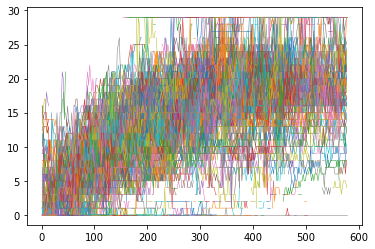

In [27]:
part_traj=[]
part_traj_rc=[]
part_traj_t=[]
part_traj_cl_label=[]
part_traj_state=[]
cl0_last_rc=[]
cl1_last_rc=[]
#------partail align to the paths
jump_out_thres=2
for ind in range(len(all_traj)):
    
    traj_rc=-1*np.ones((all_traj[ind].shape[0],2))
    part_inds=np.arange(all_traj[ind].shape[0])
    rc0_match_inds=np.unique(np.asarray(dtw_subsequence_path(all_traj[ind],extend_path0)[0])[:,1])
#     print(rc0_match_inds)
    
    rc1_match_inds=np.unique(np.asarray(dtw_subsequence_path(all_traj[ind],extend_path1)[0])[:,1])
#     print(rc1_match_inds)
    rc0_match=extend_path0[rc0_match_inds,:]
    rc1_match=extend_path1[rc1_match_inds,:]

    for i in range(len(all_traj[ind])):

        p = all_traj[ind][i,:]

        dist0 = linalg.norm(rc0_match- p[None,:], axis = 1)
        dist1 = linalg.norm(rc1_match- p[None,:], axis = 1)
        if np.amin(dist0)<np.amin(dist1):
            traj_rc[i,0]=rc0_match_inds[np.argmin(dist0)]
        else:
            traj_rc[i,1]=rc1_match_inds[np.argmin(dist1)]

    part_inds_rc0=part_inds[np.where(traj_rc[:,0]!=-1)]
    part_inds_rc1=part_inds[np.where(traj_rc[:,1]!=-1)]
#     print(traj_rc)
    
    for k in range(len(consecutive_arrs(part_inds_rc0))):
        if len(consecutive_arrs(part_inds_rc0)[k])>jump_out_thres:
            part_inds=consecutive_arrs(part_inds_rc0)[k]
            print('rc0',part_inds)
            print(traj_rc[:,0][part_inds])
            
            part_traj_t.append(all_t[ind][part_inds])
            part_traj_rc.append(traj_rc[:,0][part_inds])
            
            part_traj.append(all_traj[ind][part_inds])
            part_traj_state.append(all_traj_state[ind][part_inds])
            part_traj_cl_label.append(0)
            cl0_last_rc.extend(traj_rc[:,0][part_inds][np.where(all_t[ind][part_inds]>505)].tolist())

            plt.plot(all_t[ind][part_inds],traj_rc[:,0][part_inds],linewidth=0.5)


    
    for k in range(len(consecutive_arrs(part_inds_rc1))):
        if len(consecutive_arrs(part_inds_rc1)[k])>jump_out_thres:
            part_inds=consecutive_arrs(part_inds_rc1)[k]
            print('rc1',part_inds)
            print(traj_rc[:,1][part_inds])
            
            part_traj_t.append(all_t[ind][part_inds])
            part_traj_rc.append(traj_rc[:,1][part_inds])
            part_traj.append(all_traj[ind][part_inds])
            part_traj_state.append(all_traj_state[ind][part_inds])
            
            part_traj_cl_label.append(1)
            cl1_last_rc.extend(traj_rc[:,1][part_inds][np.where(all_t[ind][part_inds]>505)].tolist())

            plt.plot(all_t[ind][part_inds],traj_rc[:,1][part_inds],linewidth=0.5)
plt.show()

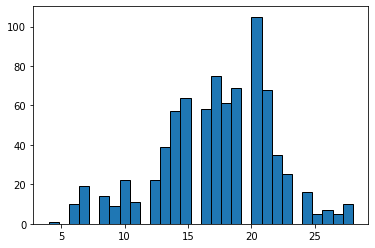

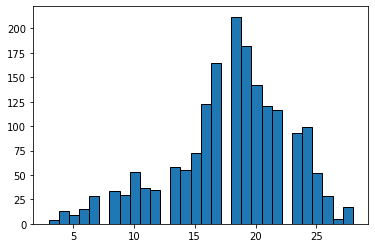

17.1635687732342
17.820255982192542


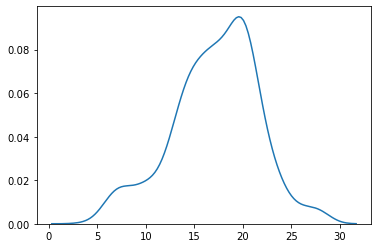

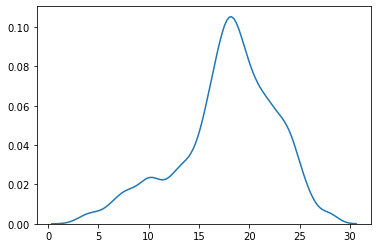

In [28]:
cl0_last_rc=np.array(cl0_last_rc)[(np.array(cl0_last_rc)>0)&(np.array(cl0_last_rc)<29)]
cl1_last_rc=np.array(cl1_last_rc)[(np.array(cl1_last_rc)>0)&(np.array(cl1_last_rc)<29)]
plt.hist(cl0_last_rc,bins=30,edgecolor='k')
plt.show()
plt.hist(cl1_last_rc,bins=30,edgecolor='k')
plt.show()

print(np.mean(cl0_last_rc))
print(np.mean(cl1_last_rc))
sns.kdeplot(cl0_last_rc)
plt.show()
sns.kdeplot(cl1_last_rc)
plt.show()

np.save(result_path+'4ng_cl0_last_rc.npy',cl0_last_rc)
np.save(result_path+'4ng_cl1_last_rc.npy',cl1_last_rc)

In [29]:
# return_rc_cl0=[]
# return_rc_cl1=[]
# for i in range(len(part_traj_rc)):
#     rc_traj=part_traj_rc[i]
#     traj_t=part_traj_t[i]
#     traj_state=part_traj_state[i]

#     if part_traj_cl_label[i]==0:
#         M_inds=np.where(traj_state==2)[0]
#         for j in range(len(M_inds)-1):
#             if M_inds[j+1]<len(traj_state)-1:
#                 if traj_state[M_inds[j]+1]==1:
#                     mask=(rc_traj[(M_inds[j]+1):M_inds[j+1]]<29)
#                     return_rc_cl0.extend(rc_traj[(M_inds[j]+1):M_inds[j+1]][mask])
                        
        
# #         if np.where(traj_t>505)[0].shape[0]>10:
# #             plt.hist(rc_traj[np.where(traj_t>505)])
# #             plt.show()
#     if part_traj_cl_label[i]==1:
#         M_inds=np.where(traj_state==2)[0]
#         for j in range(len(M_inds)-1):
#             if M_inds[j+1]<len(traj_state)-1:
#                 if traj_state[M_inds[j]+1]==1:
#                     mask=(rc_traj[(M_inds[j]+1):M_inds[j+1]]<29)
#                     return_rc_cl1.extend(rc_traj[(M_inds[j]+1):M_inds[j+1]][mask])
                    
                        
# #         if np.where(traj_t>505)[0].shape[0]>10:
# #             plt.hist(rc_traj[np.where(traj_t>505)])
# #             plt.show()
# plt.hist(return_rc_cl0,bins=30)
# plt.show()
# plt.hist(return_rc_cl1,bins=30)
# plt.show()

# print(np.mean(return_rc_cl0),np.std(return_rc_cl0))
# print(np.mean(return_rc_cl1),np.std(return_rc_cl1))

In [30]:
# part_traj_cl0=[]
# part_traj_cl1=[]
# for i in range(len(part_traj)):
#     traj=part_traj[i]
#     traj_t=part_traj_t[i]

#     if part_traj_cl_label[i]==0:
#         part_traj_cl0.append(traj)
#     else:
#         part_traj_cl1.append(traj)
# X_part_cl0=np.concatenate(part_traj_cl0,axis=0)
# X_part_cl1=np.concatenate(part_traj_cl1,axis=0)

# sns.kdeplot(X_part_cl0[:,0],X_part_cl0[:,1],cmap="Reds", n_levels=10, shade=True, shade_lowest=False)
# plt.show()
# sns.kdeplot(X_part_cl1[:,0],X_part_cl1[:,1],cmap="Blues", n_levels=10, shade=True, shade_lowest=False)
# plt.show()

# X_part=np.concatenate(part_traj,axis=0)
# sns.kdeplot(X_part[:,0],X_part[:,1],cmap="Blues", n_levels=20, shade=True, shade_lowest=False)
# plt.show()

In [31]:
rc_grad0=[[] for i in range(len(extend_path0))]
rc_grad1=[[] for i in range(len(extend_path1))]
rc_grad_sign0=[[] for i in range(len(extend_path0))]
rc_grad_sign1=[[] for i in range(len(extend_path1))]
rc_pts0=[[] for i in range(len(extend_path0))]
rc_pts1=[[] for i in range(len(extend_path1))]

rc_real_grad0=[[] for i in range(len(extend_path0))]
rc_real_grad1=[[] for i in range(len(extend_path1))]

for i in range(len(part_traj_rc)):
    rc_traj=part_traj_rc[i]
#     print(rc_traj)
    traj_len=rc_traj.shape[0]-1
    traj_t=part_traj_t[i]
    rc_traj_grad=np.diff(rc_traj,axis=0)
    traj_grad=np.diff(part_traj[i],axis=0)
#     print(rc_traj.shape,traj_t.shape)
    if part_traj_cl_label[i]==0:
        for t_ind in np.where((traj_t>=t_start)&(traj_t<t_end))[0][:-1]:
            rc_grad0[int(rc_traj[t_ind])].append((rc_traj[t_ind+1]-rc_traj[t_ind])*1.0/(traj_t[t_ind+1]-traj_t[t_ind]))
            rc_grad_sign0[int(rc_traj[t_ind])].append(np.sign((rc_traj[t_ind+1]-rc_traj[t_ind])*1.0/(traj_t[t_ind+1]-traj_t[t_ind])))
            rc_pts0[int(rc_traj[t_ind])].append(part_traj[i][t_ind,:])
            rc_real_grad0[int(rc_traj[t_ind])].append(traj_grad[t_ind,:])


    else:
        for t_ind in np.where((traj_t>=t_start)&(traj_t<t_end))[0][:-1]:
            rc_grad1[int(rc_traj[t_ind])].append((rc_traj[t_ind+1]-rc_traj[t_ind])*1.0/(traj_t[t_ind+1]-traj_t[t_ind]))
            rc_grad_sign1[int(rc_traj[t_ind])].append(np.sign((rc_traj[t_ind+1]-rc_traj[t_ind])*1.0/(traj_t[t_ind+1]-traj_t[t_ind])))
            rc_pts1[int(rc_traj[t_ind])].append(part_traj[i][t_ind,:])
            rc_real_grad1[int(rc_traj[t_ind])].append(traj_grad[t_ind,:])

[ 0.18247126  0.2688253   0.01250782  0.38135593  0.3902439   0.40972222
  0.17041199  0.23099415  0.23862928  0.07272118  0.11462729  0.0816075
  0.12028542  0.1189759   0.06569264  0.10576132  0.05143229  0.01034325
 -0.13834197 -0.1415308  -0.20500251 -0.14794469 -0.07859848 -0.02259036
 -0.05555556 -0.09047619 -0.25       -0.13953488 -0.33050847 -0.02906977]
[ 0.47840576  0.31930878  0.22277359  0.38135593  0.3902439   0.40972222
  0.17041199  0.23099415  0.23862928  0.07272118  0.11462729  0.0816075
  0.12028542  0.1189759   0.06569264  0.10576132  0.05143229  0.01034325
 -0.13834197 -0.1415308  -0.20500251 -0.14794469 -0.07859848 -0.02259036
 -0.05555556 -0.09047619 -0.45377314 -0.5296875  -0.6829926  -0.29901754]


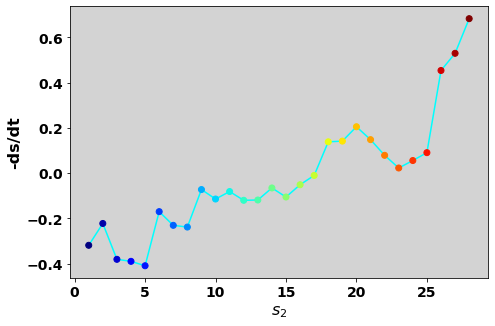

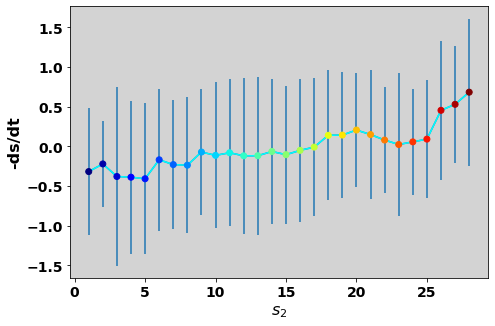

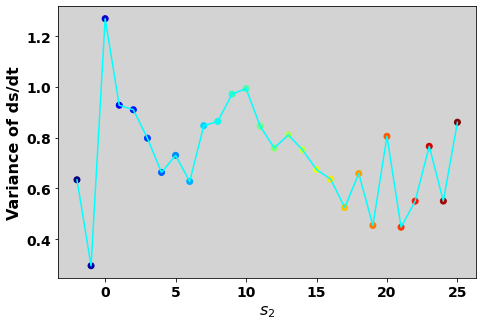

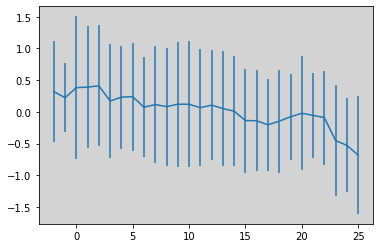

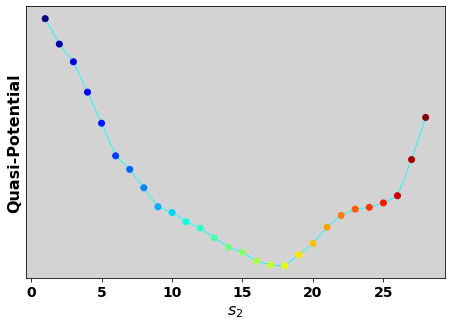

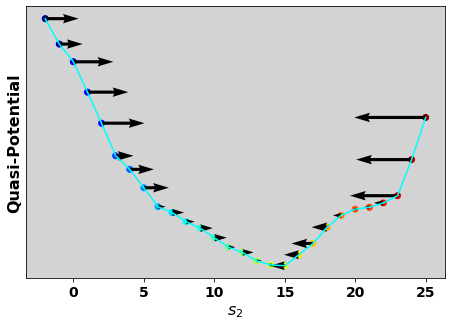

In [32]:
rc_flux_v0=np.zeros((len(extend_path),))
rc_flux_D0=np.zeros((len(extend_path),))
for j in range(len(extend_path)):
#     plt.hist(np.array(rc_grad[j]),bins=100)
#     plt.show()
    rc_flux_v0[j]=np.mean(np.array(rc_grad0[j]))
    rc_flux_D0[j]=np.var(np.array(rc_grad0[j]))
print(rc_flux_v0)
rc_flux_v0[:branch_start]=path_dsdt[:branch_start]
rc_flux_v0[branch_end-1:]=path_dsdt[branch_end-1:]
print(rc_flux_v0)


fig=plt.figure(figsize=(7.5,5))
fig.patch.set_facecolor('white')
plt.rcParams['axes.facecolor'] = 'lightgray' 
dot_color=np.arange(extend_path.shape[0]-2)
cm=plt.cm.get_cmap('jet')
plt.plot(np.arange(1,len(rc_flux_v0[1:-1])+1),-rc_flux_v0[1:-1],color='cyan',zorder=1)

plt.scatter(np.arange(1,len(rc_flux_v0[1:-1])+1),-rc_flux_v0[1:-1],c=dot_color,cmap=cm,zorder=2)
plt.xlabel('$s_2$',fontsize=16,fontweight='bold')
plt.ylabel('-ds/dt',fontsize=16,fontweight='bold')
plt.xticks(fontsize=14,fontweight='bold')
plt.yticks(fontsize=14,fontweight='bold')
plt.savefig(result_path+'rc0_dSdt.png',dpi=300)
plt.show()


fig=plt.figure(figsize=(7.5,5))
fig.patch.set_facecolor('white')
plt.rcParams['axes.facecolor'] = 'lightgray' 
dot_color=np.arange(extend_path.shape[0]-2)
cm=plt.cm.get_cmap('jet')


plt.errorbar(np.arange(1,len(rc_flux_v0[1:-1])+1),-rc_flux_v0[1:-1],yerr=np.sqrt(rc_flux_D0[1:-1]),zorder=0)
plt.plot(np.arange(1,len(rc_flux_v0[1:-1])+1),-rc_flux_v0[1:-1],color='cyan',zorder=1)

plt.scatter(np.arange(1,len(rc_flux_v0[1:-1])+1),-rc_flux_v0[1:-1],c=dot_color,cmap=cm,zorder=2)
plt.xlabel('$s_2$',fontsize=16,fontweight='bold')
plt.ylabel('-ds/dt',fontsize=16,fontweight='bold')
plt.xticks(fontsize=14,fontweight='bold')
plt.yticks(fontsize=14,fontweight='bold')
plt.savefig(result_path+'rc0_dSdt_err.png',dpi=300)
plt.show()


plt.figure(figsize=(7.5,5))
plt.plot(np.arange(-extend_range+1,path.shape[0]+extend_range-1),rc_flux_D0[1:-1],color='cyan')

plt.scatter(np.arange(-extend_range+1,path.shape[0]+extend_range-1),rc_flux_D0[1:-1],c=dot_color,cmap=cm)
plt.xlabel('$s_2$',fontsize=16,fontweight='bold')
plt.ylabel('Variance of ds/dt',fontsize=16,fontweight='bold')
plt.xticks(fontsize=14,fontweight='bold')
plt.yticks(fontsize=14,fontweight='bold')
plt.savefig(result_path+'rc0_dSdt_var.png',dpi=300)
plt.show()
plt.errorbar(np.arange(-extend_range+1,path.shape[0]+extend_range-1),rc_flux_v0[1:-1],yerr=np.sqrt(rc_flux_D0[1:-1]))
plt.show()

quasi_V0=np.zeros((rc_flux_v0.shape[0]-2,))
for k in range(len(extend_path)-2):
    quasi_V0[k]=np.sum(-rc_flux_v0[1:k+1])
plt.figure(figsize=(7.5,5))

plt.plot(np.arange(1,quasi_V0.shape[0]+1),quasi_V0,linewidth=0.8,color='cyan',zorder=1)

plt.scatter(np.arange(1,quasi_V0.shape[0]+1),quasi_V0,c=dot_color,cmap=cm,zorder=2)
plt.xlabel('$s_2$',fontsize=16,fontweight='bold')
plt.ylabel('Quasi-Potential',fontsize=16,fontweight='bold')
plt.xticks(fontsize=14,fontweight='bold')
plt.yticks([])#(fontsize=14,fontweight='bold')
plt.savefig(result_path+'rc0_potential.png',dpi=300)
plt.show()
np.save(result_path+'iU0.npy',quasi_V0)



plt.figure(figsize=(7.5,5))

plt.plot(np.arange(-extend_range+1,path.shape[0]+extend_range-1),quasi_V0,color='cyan')
plt.scatter(np.arange(-extend_range+1,path.shape[0]+extend_range-1),quasi_V0,c=dot_color,cmap=cm)
plt.xlabel('$s_2$',fontsize=16,fontweight='bold')
plt.ylabel('Quasi-Potential',fontsize=16,fontweight='bold')
plt.xticks(fontsize=14,fontweight='bold')
plt.yticks([])#(fontsize=14,fontweight='bold')
plt.quiver(np.arange(-extend_range+1,path.shape[0]+extend_range-1),quasi_V0,rc_flux_v0[1:-1],np.zeros_like(quasi_V0),scale=4)
plt.savefig(result_path+'rc0_potential_vf.png',dpi=300)

plt.show()

np.save(result_path+'rc0_var.npy',rc_flux_D0[1:-1])

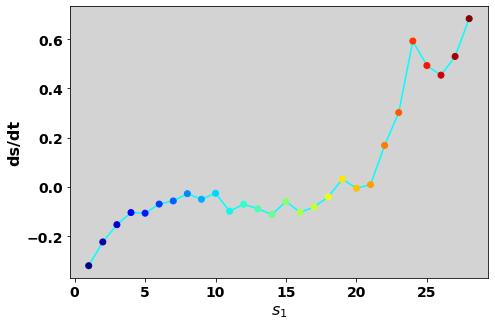

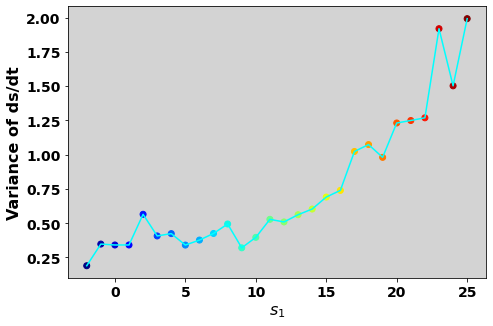

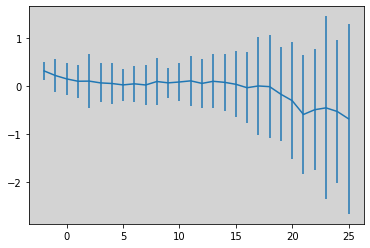

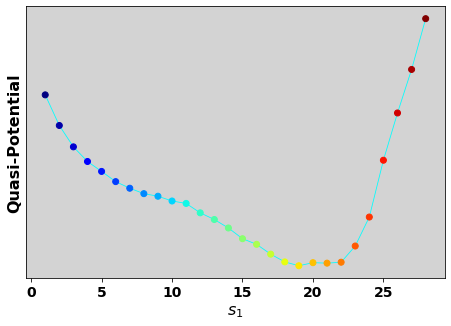

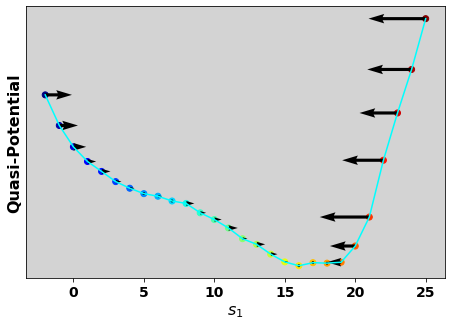

In [33]:
rc_flux_v1=np.zeros((len(extend_path),))
rc_flux_D1=np.zeros((len(extend_path),))
for j in range(len(extend_path)):
#     plt.hist(np.array(rc_grad[j]))
#     plt.show()
    rc_flux_v1[j]=np.mean(np.array(rc_grad1[j]))
    rc_flux_D1[j]=np.var(np.array(rc_grad1[j]))
    
rc_flux_v1[:branch_start]=path_dsdt[:branch_start]
rc_flux_v1[branch_end-1:]=path_dsdt[branch_end-1:]

plt.figure(figsize=(7.5,5))
fig.patch.set_facecolor('white')
plt.rcParams['axes.facecolor'] = 'lightgray' 
dot_color=np.arange(extend_path.shape[0]-2)
cm=plt.cm.get_cmap('jet')
plt.plot(np.arange(1,len(rc_flux_v1[1:-1])+1),-rc_flux_v1[1:-1],color='cyan',zorder=1)

plt.scatter(np.arange(1,len(rc_flux_v1[1:-1])+1),-rc_flux_v1[1:-1],c=dot_color,cmap=cm,zorder=2)
plt.xlabel('$s_1$',fontsize=16,fontweight='bold')
plt.ylabel('ds/dt',fontsize=16,fontweight='bold')
plt.xticks(fontsize=14,fontweight='bold')
plt.yticks(fontsize=14,fontweight='bold')
plt.savefig(result_path+'rc1_dSdt.png',dpi=300)
plt.show()

plt.figure(figsize=(7.5,5))
plt.plot(np.arange(-extend_range+1,path.shape[0]+extend_range-1),rc_flux_D1[1:-1],color='cyan')

plt.scatter(np.arange(-extend_range+1,path.shape[0]+extend_range-1),rc_flux_D1[1:-1],c=dot_color,cmap=cm)
plt.xlabel('$s_1$',fontsize=16,fontweight='bold')
plt.ylabel('Variance of ds/dt',fontsize=16,fontweight='bold')
plt.xticks(fontsize=14,fontweight='bold')
plt.yticks(fontsize=14,fontweight='bold')
plt.savefig(result_path+'rc1_dSdt_var.png',dpi=300)
plt.show()
plt.errorbar(np.arange(-extend_range+1,path.shape[0]+extend_range-1),rc_flux_v1[1:-1],yerr=rc_flux_D1[1:-1])
plt.show()

quasi_V1=np.zeros((rc_flux_v1.shape[0]-2,))
for k in range(len(extend_path)-2):
    quasi_V1[k]=np.sum(-rc_flux_v1[1:k+1])
plt.figure(figsize=(7.5,5))
plt.plot(np.arange(1,quasi_V1.shape[0]+1),quasi_V1,linewidth=0.8,color='cyan',zorder=1)

plt.scatter(np.arange(1,quasi_V1.shape[0]+1),quasi_V1,c=dot_color,cmap=cm,zorder=2)
plt.xlabel('$s_1$',fontsize=16,fontweight='bold')
plt.ylabel('Quasi-Potential',fontsize=16,fontweight='bold')
plt.xticks(fontsize=14,fontweight='bold')
plt.yticks([])#(fontsize=14,fontweight='bold')
plt.savefig(result_path+'rc1_potential.png',dpi=300)
plt.show()
np.save(result_path+'iU1.npy',quasi_V1)
plt.figure(figsize=(7.5,5))

plt.plot(np.arange(-extend_range+1,path.shape[0]+extend_range-1),quasi_V1,color='cyan')
plt.scatter(np.arange(-extend_range+1,path.shape[0]+extend_range-1),quasi_V1,c=dot_color,cmap=cm)
plt.xlabel('$s_1$',fontsize=16,fontweight='bold')
plt.ylabel('Quasi-Potential',fontsize=16,fontweight='bold')
plt.xticks(fontsize=14,fontweight='bold')
plt.yticks([])#(fontsize=14,fontweight='bold')
plt.quiver(np.arange(-extend_range+1,path.shape[0]+extend_range-1),quasi_V1,rc_flux_v1[1:-1],np.zeros_like(quasi_V1),scale=5)
plt.savefig(result_path+'rc1_potential_vf.png',dpi=300)

plt.show()

np.save(result_path+'rc1_var.npy',rc_flux_D1[1:-1])